# 需求


![](./img/微信图片_20220526105612.png)

产：焦化外供

销：套筒窑3个（烧结厂），放散1个，炼钢厂1个，西区锅炉1个（发电厂）


# Pre-processing

历史数据是按分钟采集的，由于波动的存在，对于一定时间窗口内流量变化梯度的求解未必准确。因此，后续部分要考虑时间窗口内数据的滤波处理、异常值识别处理。

In [1]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
import matplotlib.pyplot as plt
import matplotlib

In [3]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [5]:
FileNames=os.listdir('./data/')
print('文件列表：')
for x in FileNames:
    print(x)

FileNames = [
    '焦化三期外供煤气流量.csv',
    '1#套筒窑进口总管瞬时流量.csv',
    '3#套筒窑进口总管瞬时流量.csv',
    '4#套筒窑进口总管瞬时流量.csv',
    '炼钢厂焦炉煤气进口总管瞬时流量.csv',
    '西区100T锅炉焦炉煤气总管瞬时流量.csv',
    '焦化三期放散塔瞬时流量.csv',
]
print('\n提取列表：')
for x in FileNames:
    print(x)

serNames = ['焦化外供','套筒窑1','套筒窑2','套筒窑3','炼钢厂','锅炉','焦化放散']


文件列表：
1#套筒窑进口总管瞬时流量.csv
3#套筒窑进口总管瞬时流量.csv
4#套筒窑进口总管瞬时流量.csv
炼钢厂焦炉煤气进口总管瞬时流量.csv
焦化三期外供煤气流量.csv
焦化三期放散塔瞬时流量.csv
西区100T锅炉焦炉煤气总管瞬时流量.csv

提取列表：
焦化三期外供煤气流量.csv
1#套筒窑进口总管瞬时流量.csv
3#套筒窑进口总管瞬时流量.csv
4#套筒窑进口总管瞬时流量.csv
炼钢厂焦炉煤气进口总管瞬时流量.csv
西区100T锅炉焦炉煤气总管瞬时流量.csv
焦化三期放散塔瞬时流量.csv


In [6]:
ser = pd.read_csv('./data/'+FileNames[0], encoding='gb18030', index_col=False)
data = np.zeros((len(ser),len(serNames)))

for i in range(len(FileNames)):
    ser = pd.read_csv('./data/'+FileNames[i], encoding='gb18030', index_col=False)
    data[:,i] = ser['值'].values

ser = pd.DataFrame(data, columns=serNames)
ser

C:\bigCong\env\py37_1_tf\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


焦化外供         套筒窑1         套筒窑2         套筒窑3          炼钢厂  \
0       25467.338037   541.428861  4106.154383  3689.881443  7776.021483   
1       31286.218463   551.789307  4107.876714  3689.791693  7626.024847   
2       27052.133988   554.211750  4109.599045  3689.701942  7751.425194   
3       26449.380349   557.664914  4111.321376  3689.612192  7759.828599   
4       27623.320584   504.572694  4113.043708  3689.522441  7781.008152   
...              ...          ...          ...          ...          ...   
132475  21368.095128  1355.322969   568.961306     0.000005  5618.701037   
132476  21662.745531  1336.454296   560.241123     0.000005  5463.675277   
132477  24639.599501  1284.591330   649.060286     0.000005  5409.511025   
132478  21754.553512  1311.176787   519.891020     0.000005  5347.181945   
132479  21167.228577  1276.500679   490.625415     0.000005  5437.968611   

                 锅炉         焦化放散  
0       6687.897648  3457.050708  
1       6606.700431  5704.971697  
2       6413.561240  5393.052193  
3       6792.389245  3605.506864  
4       6866.979935  4705.525809  
...             ...          ...  
132475  3708.340618   103.000000  
132476  3703.717722   103.000000  
132477  3700.878349   103.000000  
132478  3706.929803   103.000000  
132479  3706.271309   103.000000  

[132480 rows x 7 columns]

In [6]:
ser.describe().values[-1,:]*1.1

array([70060.4413542,  3246.7298028,  5653.806565 ,  4061.7024118,
       11000.0000209, 16089.2271936, 16500.       ])

## 分钟变化曲线-局部

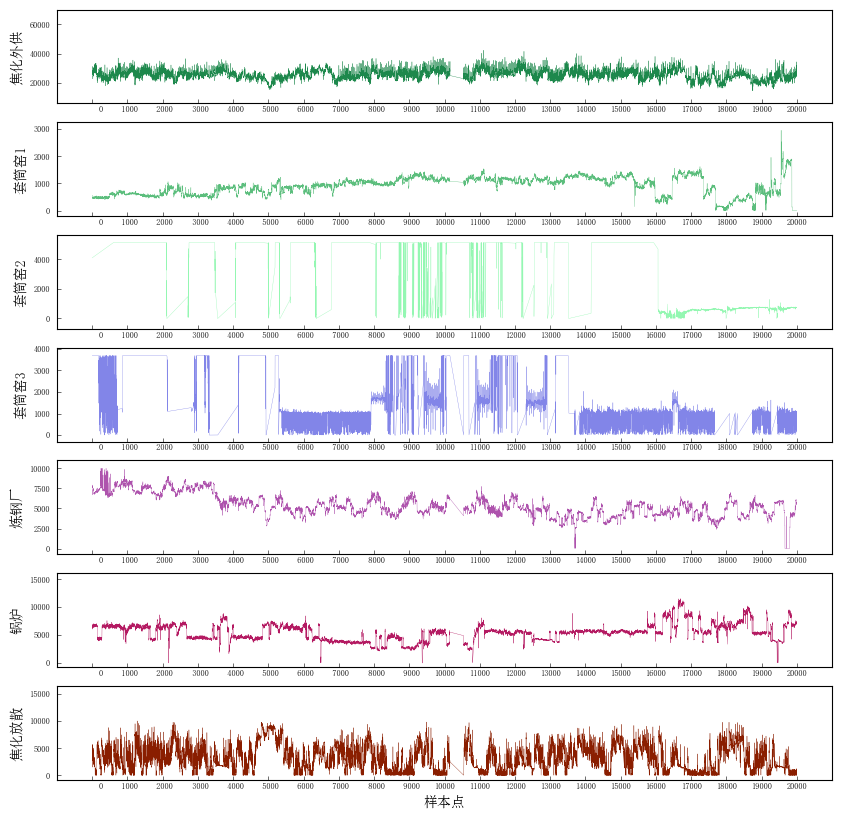

In [7]:

s=0
e=20000
# 将配置重置为默认值
plt.rcdefaults()
config = {
            "font.family": 'serif',
            "font.size": 15,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
plt.rcParams.update(config)
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

fig,ax = plt.subplots(7,1,figsize=(10, 10)) #注意:一般都在ax中设置,不再plot中设置, dpi=600
#     plt.figure(figsize=(8, 4), dpi=160)  # 设置画布大小、像素

num = np.array(range(s,e))
ymin = [6000,-200,-700,-300,-700,-700,-800]
# ymax = [55000,4000,6400,4500,12000,12000,12000]
ymax = ser.describe().values[-1,:]*1.1
colors = ['#1D884C','#5CBE7D','#94F7B2','#8285E8','#AE53AD','#B41A62','#8A1E00']

for i in range(ser.shape[1]):
    ax[i].plot(num, ser.values[:,i][s:e], c=colors[i], alpha=1, linewidth=0.24)    # 左闭右开

    #修改主刻度
    xmajorLocator = MultipleLocator(1000) #将x主刻度标签设置为 的倍数
    xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
#     ymajorLocator = MultipleLocator(5000) #将y轴主刻度标签设置为 的倍数
    ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
    #设置主刻度标签的位置,标签文本的格式
    ax[i].xaxis.set_major_locator(xmajorLocator)
    ax[i].xaxis.set_major_formatter(xmajorFormatter)
#     ax[i].yaxis.set_major_locator(ymajorLocator)
#     ax[i].yaxis.set_major_formatter(ymajorFormatter)
    #修改次刻度
    #     xminorLocator = MultipleLocator(1) #将x轴次刻度标签设置为5的倍数
#     yminorLocator = MultipleLocator(1000) #将此y轴次刻度标签设置为0.1的倍数
    #设置次刻度标签的位置,没有标签文本格式
    #     ax.xaxis.set_minor_locator(xminorLocator)
#     ax[i].yaxis.set_minor_locator(yminorLocator)

    ax[i].tick_params(axis='x', labelsize=6, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
    ax[i].tick_params(axis='y', labelsize=6, direction='in', pad=5, length=2.7, width=0.4)
    ax[i].tick_params(axis="x", which='minor', direction='in', length=2, width=0.3, color="green")
    ax[i].tick_params(axis="y", which='minor', direction='in', length=2, width=0.3, color="green")

    # plt.title('pic', fontsize=15)
    plt.xlabel('样本点', fontsize=10)  # 设置 x 轴标签、字体大小
    ax[i].set_ylabel(serNames[i], fontsize=10)  # 设置 y 轴标签、字体大小
    # plt.xlim(-2,22)
    ax[i].set_ylim(ymin[i],ymax[i])
    #     if int((end - start) / 10) > 10:
    #         x_major_locator = plt.MultipleLocator(int((end-start+1)/10))  # MultipleLocator()函数设置了x轴相邻显示点的间隔；显示10个刻度值
    #         ax = plt.gca()
    #         ax.xaxis.set_major_locator(x_major_locator)
    # plt.grid()  # 网格
    # plt.gcf().autofmt_xdate()  # 自动旋转日期标记
# plt.savefig('./output/曲线.png', dpi=600)
plt.show()


## 分钟变化曲线-整体

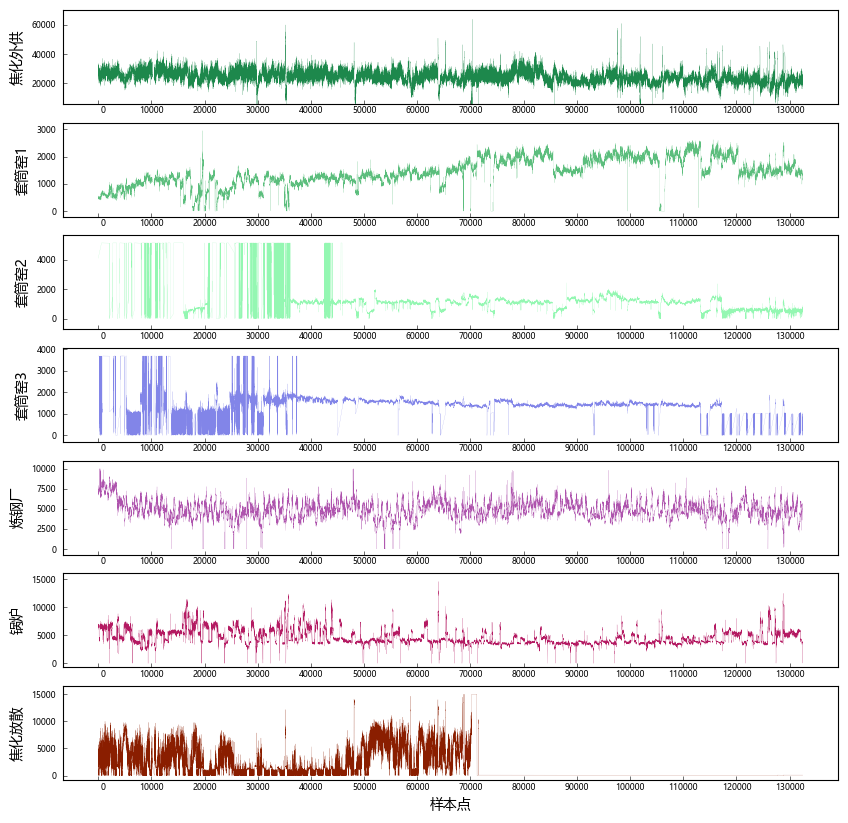

In [8]:

s=0
e=len(ser)
# 将配置重置为默认值
plt.rcdefaults()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

fig,ax = plt.subplots(7,1,figsize=(10, 10)) #注意:一般都在ax中设置,不再plot中设置, dpi=600
#     plt.figure(figsize=(8, 4), dpi=160)  # 设置画布大小、像素

num = np.array(range(s,e))
# ymin = [6000,-200,-700,-300,-700,-700,-800]
# ymax = [45000,2400,6400,4500,12000,12000,12000]
colors = ['#1D884C','#5CBE7D','#94F7B2','#8285E8','#AE53AD','#B41A62','#8A1E00']

for i in range(ser.shape[1]):
    ax[i].plot(num, ser.values[:,i][s:e], c=colors[i], alpha=1, linewidth=0.1)    # 左闭右开

    #修改主刻度
    xmajorLocator = MultipleLocator(10000) #将x主刻度标签设置为 的倍数
    xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
#     ymajorLocator = MultipleLocator(5000) #将y轴主刻度标签设置为 的倍数
    ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
    #设置主刻度标签的位置,标签文本的格式
    ax[i].xaxis.set_major_locator(xmajorLocator)
    ax[i].xaxis.set_major_formatter(xmajorFormatter)
#     ax[i].yaxis.set_major_locator(ymajorLocator)
#     ax[i].yaxis.set_major_formatter(ymajorFormatter)
    #修改次刻度
    #     xminorLocator = MultipleLocator(1) #将x轴次刻度标签设置为5的倍数
#     yminorLocator = MultipleLocator(1000) #将此y轴次刻度标签设置为0.1的倍数
    #设置次刻度标签的位置,没有标签文本格式
    #     ax.xaxis.set_minor_locator(xminorLocator)
#     ax[i].yaxis.set_minor_locator(yminorLocator)

    ax[i].tick_params(axis='x', labelsize=6, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
    ax[i].tick_params(axis='y', labelsize=6, direction='in', pad=5, length=2.7, width=0.4)
    ax[i].tick_params(axis="x", which='minor', direction='in', length=2, width=0.3, color="green")
    ax[i].tick_params(axis="y", which='minor', direction='in', length=2, width=0.3, color="green")

    # plt.title('pic', fontsize=15)
    plt.xlabel('样本点', fontsize=10)  # 设置 x 轴标签、字体大小
    ax[i].set_ylabel(serNames[i], fontsize=10)  # 设置 y 轴标签、字体大小
    # plt.xlim(-2,22)
    ax[i].set_ylim(ymin[i],ymax[i])
    #     if int((end - start) / 10) > 10:
    #         x_major_locator = plt.MultipleLocator(int((end-start+1)/10))  # MultipleLocator()函数设置了x轴相邻显示点的间隔；显示10个刻度值
    #         ax = plt.gca()
    #         ax.xaxis.set_major_locator(x_major_locator)
    # plt.grid()  # 网格
    # plt.gcf().autofmt_xdate()  # 自动旋转日期标记
# plt.savefig('./output/曲线2.png', dpi=600)
plt.show()


In [9]:
# 显示有空值的条目
ser[ser.isnull().T.any()]

Empty DataFrame
Columns: [焦化外供, 套筒窑1, 套筒窑2, 套筒窑3, 炼钢厂, 锅炉, 焦化放散]
Index: []

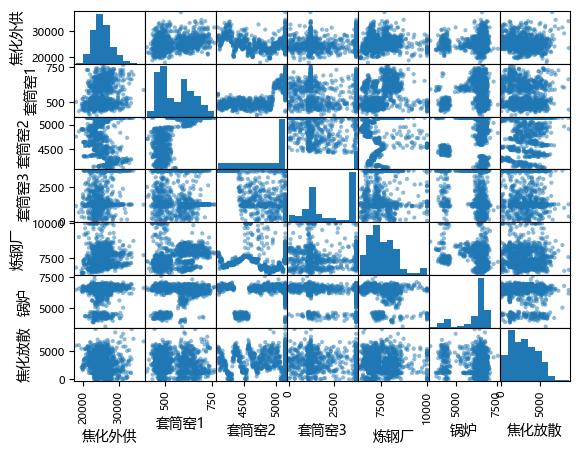

In [10]:
# 绘制散点图矩阵
pd.plotting.scatter_matrix(ser[0:1000])
plt.show()

# 数据分析-优先级制定

## 煤气产销量相关度优先级定制

皮尔逊相关系数反映的是变量之间线性相关程度，皮尔逊相关系数可以看成是剔除了变量量纲影响，即将变量标准化后计算得到的协方差。由于数据质量和实际工况下各设备线性相关不明显的原因，现阶段这部分工作对于细致的权重分配计算贡献程度较为有限。

这部分对焦炉煤气产销相关度进行计算，采用皮尔逊相关系数对煤气产销量的相关性进行描述，从而在此基础上为用户端设备的煤气供应提供宏观的优先级判断，在进一步的研究中可以考虑通过一定的系数体现以上工作对具体过程的调控。

考虑进一步结合以其它方式计算的相关系数，综合比较分析，避免单一相关系数计算方法本身对数据分布特征有一定要求的局限性。

根据相关系数输出结果来看，采用全部数据计算相关系数，不同特征变量间的相关程度差异不明显。例如用全部数据计算出的灰色关联度系数在数值上都较大，也就是说变量间彼此都存在相关性，但强弱已经难以区分。而用全部数据计算出的皮尔逊相关系数都较小，难以区分变量特征间的线性相关程度。产生这种现象的原因可能是数据量过大，设备在不同工作阶段彼此间的相关性也会起伏变化，当采用过多的数据进行一次性计算，这些相关特征就会彼此抵消，呈现比较平均化的统计特点。

针对此现象现提出采用阶段性的数据片段进行设备流量特征相关性的计算，因为阶段性的数据能够反应相对单一的工况下设备工作特点。运算结果显示不同阶段不同设备的流量呈现不同的相关性，这也表明了在分配煤气使用量的权重时，首先对设备工作状况进行辨别区分是有必要的。

### 皮尔逊相关系数

#### 整体数据的

In [11]:
correlation = ser.corr(method="pearson")
# 保留小数
for x in (correlation.columns):
    correlation[x]=correlation[x].round(decimals=3)
correlation

焦化外供   套筒窑1   套筒窑2   套筒窑3    炼钢厂     锅炉   焦化放散
焦化外供  1.000 -0.093  0.161  0.182  0.186  0.243  0.089
套筒窑1 -0.093  1.000 -0.327 -0.047 -0.099 -0.317 -0.306
套筒窑2  0.161 -0.327  1.000  0.357  0.103  0.159  0.114
套筒窑3  0.182 -0.047  0.357  1.000  0.167 -0.025  0.114
炼钢厂   0.186 -0.099  0.103  0.167  1.000 -0.064  0.008
锅炉    0.243 -0.317  0.159 -0.025 -0.064  1.000  0.036
焦化放散  0.089 -0.306  0.114  0.114  0.008  0.036  1.000

In [12]:
correlation.columns = ['焦化外供', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '']
correlation.index = ['', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '焦化放散']
for i in range(len(correlation)):
    for j in range(i+1):
        correlation.iloc[j,i] = np.NAN
correlation

焦化外供   套筒窑1   套筒窑2   套筒窑3    炼钢厂     锅炉    
        NaN    NaN    NaN    NaN    NaN    NaN NaN
套筒窑1 -0.093    NaN    NaN    NaN    NaN    NaN NaN
套筒窑2  0.161 -0.327    NaN    NaN    NaN    NaN NaN
套筒窑3  0.182 -0.047  0.357    NaN    NaN    NaN NaN
炼钢厂   0.186 -0.099  0.103  0.167    NaN    NaN NaN
锅炉    0.243 -0.317  0.159 -0.025 -0.064    NaN NaN
焦化放散  0.089 -0.306  0.114  0.114  0.008  0.036 NaN

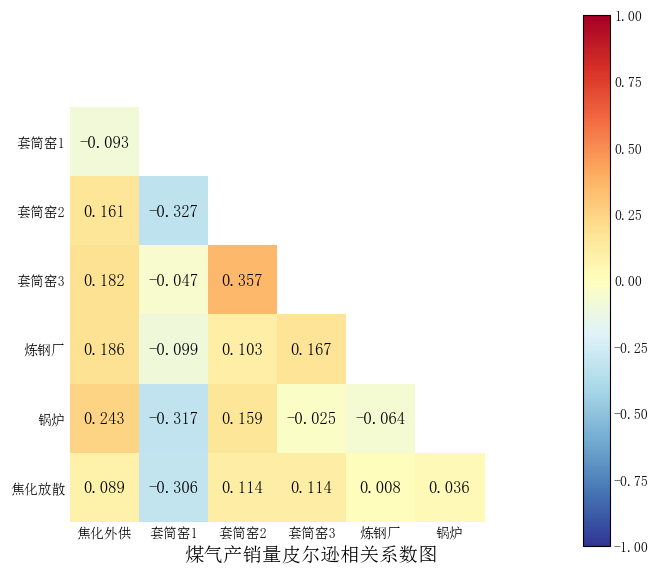

In [13]:
plt.rcdefaults()
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
plt.rcParams.update(config)
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

plt.figure(figsize=(7, 6)) # 创建画板,dpi=150
ax = plt.axes()

im = ax.imshow(correlation, cmap="RdYlBu_r", vmin=-1, vmax=1)#

# 相关系数显示
for i in range(len(correlation)):
    for j in range(i):
        text = plt.text(j, i, correlation.iloc[i, j], ha="center", va="center", color="black")

# 横轴相关设置
ax.tick_params(axis='x', labelsize=10, direction='in', pad=3, length=2.7, width=0)
ax.set_xticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
ax.set_xticklabels(correlation.columns, rotation=0)  # 设置x轴标签旋转角度
ax.set_xlabel("煤气产销量皮尔逊相关系数图", fontsize=14)
# 纵轴相关设置
ax.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)
ax.set_yticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
ax.set_yticklabels(correlation.index)

# plt.colorbar(im).ax.set_ylabel("", rotation=0)
a = plt.colorbar(im).ax
# a.set_ylabel("", rotation=0)
# a.spines['top'].set_visible(False)
# a.spines['right'].set_visible(False)
# a.spines['bottom'].set_visible(False)
# a.spines['left'].set_visible(False)
a.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)

#去掉边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
# plt.savefig('./output/pearson/皮尔逊相关系数分布.png', dpi=600)
plt.show()

#### 部分时间段各设备流量的皮尔逊相关系数

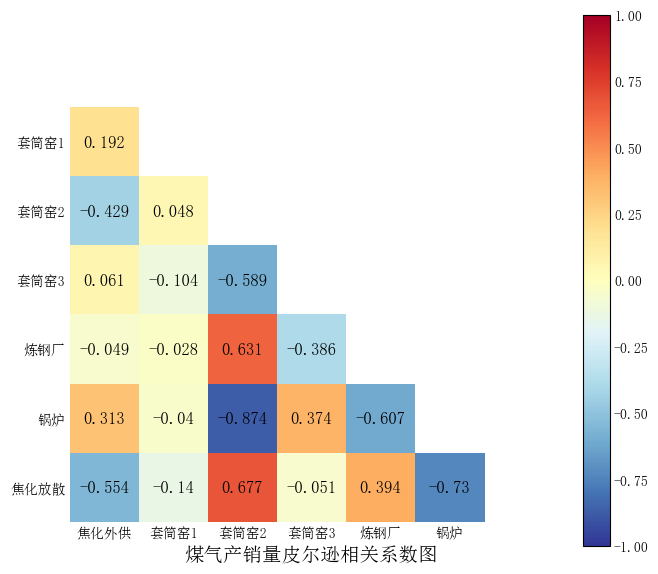

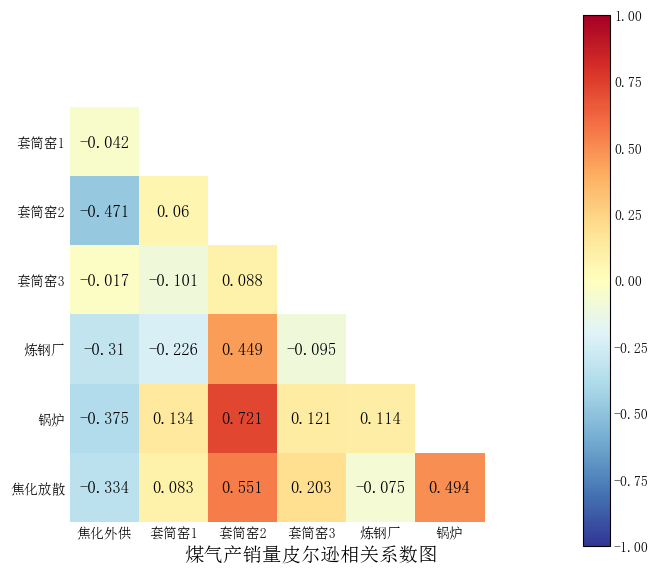

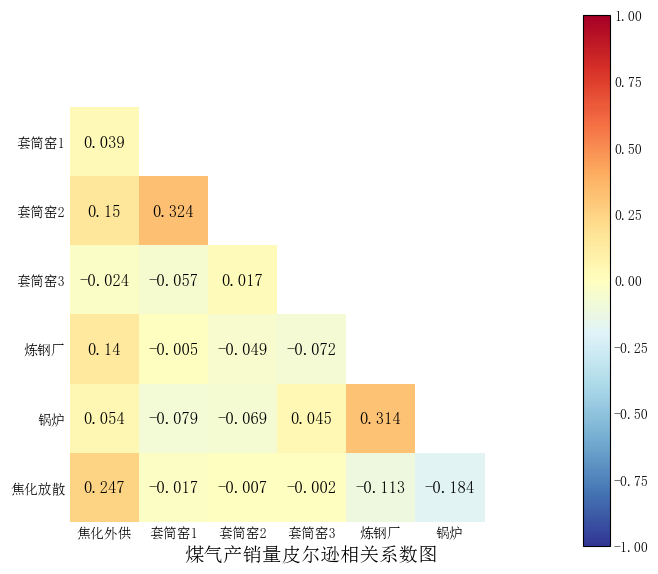

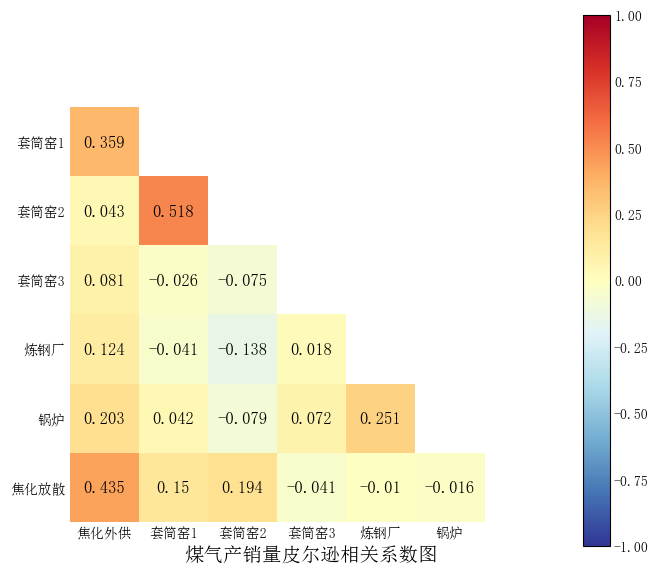

In [14]:
points = [100,200,300,400]

num = 0
for point in points:
    num +=1

    correlation = ser[point:point+100].corr(method="pearson")
    # 保留小数
    for x in (correlation.columns):
        correlation[x]=correlation[x].round(decimals=3)

    correlation.columns = ['焦化外供', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '']
    correlation.index = ['', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '焦化放散']
    for i in range(len(correlation)):
        for j in range(i+1):
            correlation.iloc[j,i] = np.NAN

    plt.rcdefaults()
    config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
    plt.rcParams.update(config)
#     plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

    plt.figure(figsize=(7, 6)) # 创建画板,dpi=150
    ax = plt.axes()

    im = ax.imshow(correlation, cmap="RdYlBu_r", vmin=-1, vmax=1)#

    # 相关系数显示
    for i in range(len(correlation)):
        for j in range(i):
            text = plt.text(j, i, correlation.iloc[i, j], ha="center", va="center", color="black")

    # 横轴相关设置
    ax.tick_params(axis='x', labelsize=10, direction='in', pad=3, length=2.7, width=0)
    ax.set_xticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
    ax.set_xticklabels(correlation.columns, rotation=0)  # 设置x轴标签旋转角度
    ax.set_xlabel("煤气产销量皮尔逊相关系数图", fontsize=14)
    # 纵轴相关设置
    ax.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)
    ax.set_yticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
    ax.set_yticklabels(correlation.index)

    # plt.colorbar(im).ax.set_ylabel("", rotation=0)
    a = plt.colorbar(im).ax
    # a.set_ylabel("", rotation=0)
    # a.spines['top'].set_visible(False)
    # a.spines['right'].set_visible(False)
    # a.spines['bottom'].set_visible(False)
    # a.spines['left'].set_visible(False)
    a.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)

    #去掉边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
#     plt.savefig('./output/pearson/皮尔逊相关系数分布_part' + str(num) + '.png', dpi=600)
    plt.show()

#### 进一步可探究在整体数据上采用滑动窗口计算局部相关性，形成相关性随时间变化的曲线

时间问题暂未进行，从以上采用数据片段或全部数据一次计算的相关系数，不同变量间总计16个值，所以用滑移窗口进行计算将会有16条皮尔逊系数值曲线。

### 灰色关联度分析

In [15]:
# 无量纲化（x-mean）/（max-min）
def dimensionlessProcessing(df):
    newDataFrame = pd.DataFrame(index=df.index)
    columns = df.columns.tolist()
    for c in columns:
        d = df[c]
        MAX = d.max()
        MIN = d.min()
        MEAN = d.mean()
        newDataFrame[c] = ((d - MEAN) / (MAX - MIN)).tolist()
    return newDataFrame

# 计算一个dataframe中单独某一列灰色关联分析度的方法，m代表参考列
def GRA_ONE(gray, m=0):
    # 读取为df格式
    gray = dimensionlessProcessing(gray)
    # 标准化
    std = gray.iloc[:, m]  # 为标准要素
    gray.drop(str(m),axis=1,inplace=True)
    ce = gray.iloc[:, 0:]  # 为比较要素
    shape_n, shape_m = ce.shape[0], ce.shape[1]  # 计算行列

    # 与标准要素比较，相减
    a = np.zeros([shape_m, shape_n])
    for i in range(shape_m):
        for j in range(shape_n):
            a[i, j] = abs(ce.iloc[j, i] - std[j])

    # 取出矩阵中最大值与最小值
    c, d = np.amax(a), np.amin(a)

    # 计算值
    result = np.zeros([shape_m, shape_n])
    for i in range(shape_m):
        for j in range(shape_n):
            result[i, j] = (d + 0.5 * c) / (a[i, j] + 0.5 * c)

    # 求均值，得到灰色关联值,并返回
    result_list = [np.mean(result[i, :]) for i in range(shape_m)]
    result_list.insert(m,1)
    return pd.DataFrame(result_list)

# 借助前两个方法实现的计算矩阵
def GRA(DataFrame):
    df = DataFrame.copy()
    list_columns = [
        str(s) for s in range(len(df.columns)) if s not in [None]
    ]
    df_local = pd.DataFrame(columns=list_columns)
    df.columns=list_columns
    for i in range(len(df.columns)):
        df_local.iloc[:, i] = GRA_ONE(df, m=i)[0]
    return df_local


#### 整体数据的关联度

In [16]:
correlation = GRA(ser)
# 保留小数
for x in (correlation.columns):
    correlation[x]=correlation[x].round(decimals=3)
correlation

0      1      2      3      4      5      6
0  1.000  0.828  0.764  0.845  0.873  0.885  0.862
1  0.818  1.000  0.706  0.774  0.796  0.769  0.775
2  0.777  0.735  1.000  0.774  0.752  0.754  0.798
3  0.859  0.804  0.780  1.000  0.824  0.805  0.815
4  0.882  0.819  0.752  0.820  1.000  0.830  0.841
5  0.902  0.810  0.771  0.815  0.844  1.000  0.859
6  0.853  0.775  0.776  0.785  0.820  0.827  1.000

In [17]:
correlation.columns = ['焦化外供', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '']
correlation.index = ['', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '焦化放散']
for i in range(len(correlation)):
    for j in range(i+1):
        correlation.iloc[j,i] = np.NAN
correlation

焦化外供   套筒窑1   套筒窑2   套筒窑3    炼钢厂     锅炉    
        NaN    NaN    NaN    NaN    NaN    NaN NaN
套筒窑1  0.818    NaN    NaN    NaN    NaN    NaN NaN
套筒窑2  0.777  0.735    NaN    NaN    NaN    NaN NaN
套筒窑3  0.859  0.804  0.780    NaN    NaN    NaN NaN
炼钢厂   0.882  0.819  0.752  0.820    NaN    NaN NaN
锅炉    0.902  0.810  0.771  0.815  0.844    NaN NaN
焦化放散  0.853  0.775  0.776  0.785  0.820  0.827 NaN

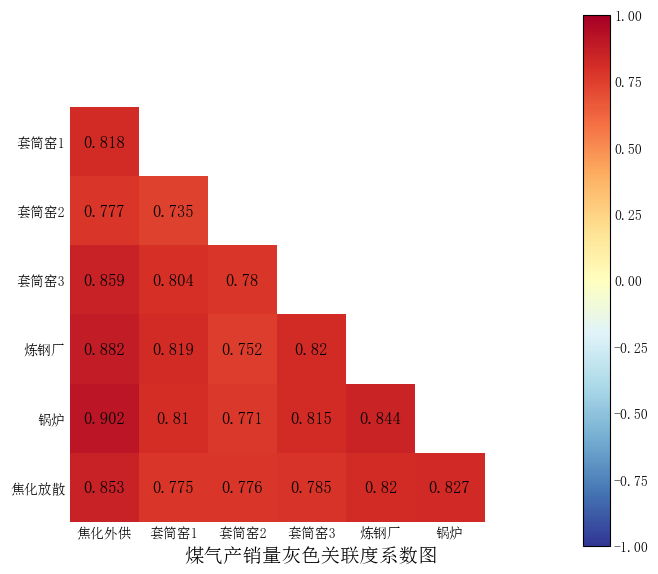

In [18]:
plt.rcdefaults()
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
plt.rcParams.update(config)
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

plt.figure(figsize=(7, 6)) # 创建画板,dpi=150
ax = plt.axes()

im = ax.imshow(correlation, cmap="RdYlBu_r", vmin=-1, vmax=1)#

# 相关系数显示
for i in range(len(correlation)):
    for j in range(i):
        text = plt.text(j, i, correlation.iloc[i, j], ha="center", va="center", color="black")

# 横轴相关设置
ax.tick_params(axis='x', labelsize=10, direction='in', pad=3, length=2.7, width=0)
ax.set_xticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
ax.set_xticklabels(correlation.columns, rotation=0)  # 设置x轴标签旋转角度
ax.set_xlabel("煤气产销量灰色关联度系数图", fontsize=14)
# 纵轴相关设置
ax.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)
ax.set_yticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
ax.set_yticklabels(correlation.index)

# plt.colorbar(im).ax.set_ylabel("", rotation=0)
a = plt.colorbar(im).ax
# a.set_ylabel("", rotation=0)
# a.spines['top'].set_visible(False)
# a.spines['right'].set_visible(False)
# a.spines['bottom'].set_visible(False)
# a.spines['left'].set_visible(False)
a.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)

#去掉边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
# plt.savefig('./output/gra/灰色关联度系数分布.png', dpi=600)
plt.show()

#### 部分时间段的关联度

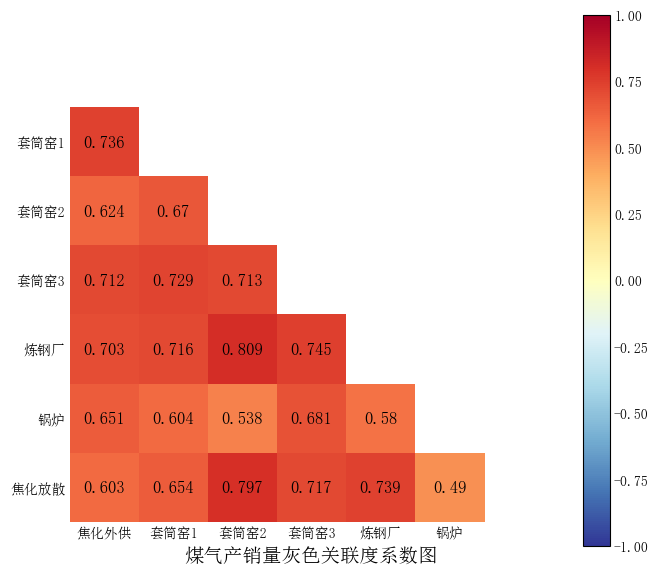

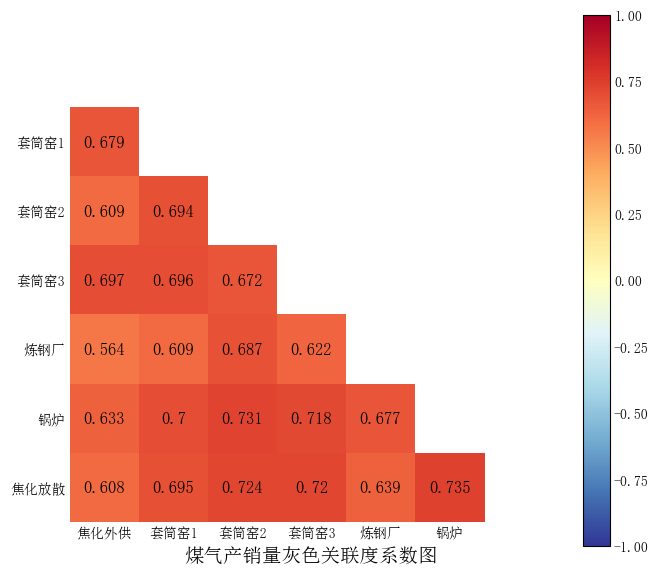

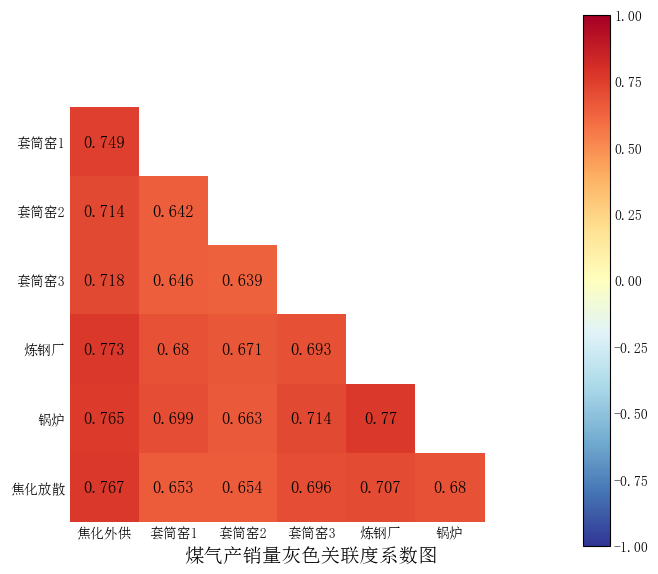

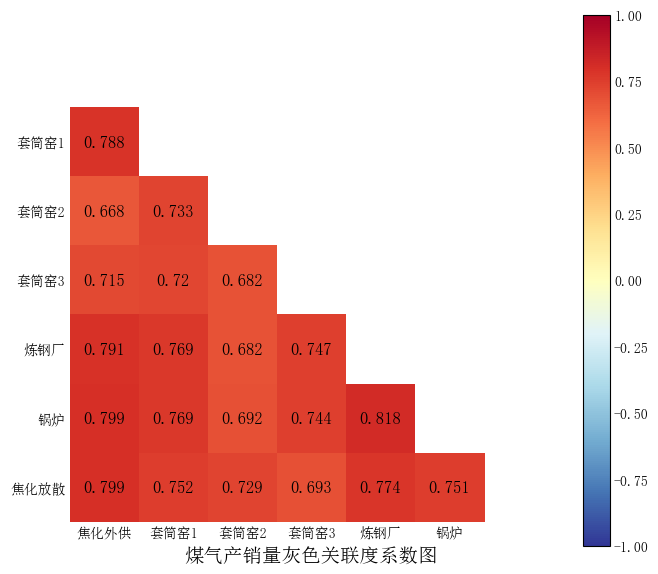

In [19]:

num = 0
for point in points:
    num +=1

    correlation = GRA(ser[point:point+100].reset_index(drop=True))
    # 保留小数
    for x in (correlation.columns):
        correlation[x]=correlation[x].round(decimals=3)

    correlation.columns = ['焦化外供', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '']
    correlation.index = ['', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '焦化放散']
    for i in range(len(correlation)):
        for j in range(i+1):
            correlation.iloc[j,i] = np.NAN

    plt.rcdefaults()
    config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
    plt.rcParams.update(config)
#     plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

    plt.figure(figsize=(7, 6)) # 创建画板,dpi=150
    ax = plt.axes()

    im = ax.imshow(correlation, cmap="RdYlBu_r", vmin=-1, vmax=1)#

    # 相关系数显示
    for i in range(len(correlation)):
        for j in range(i):
            text = plt.text(j, i, correlation.iloc[i, j], ha="center", va="center", color="black")

    # 横轴相关设置
    ax.tick_params(axis='x', labelsize=10, direction='in', pad=3, length=2.7, width=0)
    ax.set_xticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
    ax.set_xticklabels(correlation.columns, rotation=0)  # 设置x轴标签旋转角度
    ax.set_xlabel("煤气产销量灰色关联度系数图", fontsize=14)
    # 纵轴相关设置
    ax.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)
    ax.set_yticks(np.array(range(0,len(correlation))))  # 设置x轴坐标
    ax.set_yticklabels(correlation.index)

    # plt.colorbar(im).ax.set_ylabel("", rotation=0)
    a = plt.colorbar(im).ax
    # a.set_ylabel("", rotation=0)
    # a.spines['top'].set_visible(False)
    # a.spines['right'].set_visible(False)
    # a.spines['bottom'].set_visible(False)
    # a.spines['left'].set_visible(False)
    a.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)

    #去掉边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
#     plt.savefig('./output/gra/灰色关联度系数分布_part'+str(num)+'.png', dpi=600)
    plt.show()

## 煤气使用量权重优先级定制

焦炉煤气流量的历史数据分布情况如图，此图反映了煤气生产侧和用户侧设备管道中煤气流量的均值、中位数、众数、异常值等信息。总体上看各设备工作中流量分布在特定区间，可据此制定煤气使用量的权重分配。但是每种数据在分布上未体现出更加一般性的统计分布规律，实际采集存储的历史数据分布不均并存在一定程度的离群值。

结合流量实时数据的曲线图，也能看出在部分时段设备的流量数据会发生剧烈波动，以及一些突然的跳变，这些现象的原因可能有：设备的一般停启、工况变化、测量设备损坏、数据传输或写入异常等。实际环境中的这种并不稳定的流量数据给数据的分析利用造成了一定难度，因此对设备工作状态的识别对于流量权重分配有一定指导意义。

这部分研究暂在理论上提出一种根据不同工况分别计算煤气使用量权重的方法。我们首先通过人工辨别对一种设备的流量数据进行筛选，将数据分割为几种典型的工作状况，这部分也可以进一步研究结合聚类方法以定量的实现模式辨别；接着计算分析对应工况下的流量均值或是概率分布等统计信息；最后从煤气使用量配比的角度出发，利用不同设备不同工况的统计分析结果进行权重组合的计算。

历史数据处理步骤：

- 识别并分割单设备的不同工况数据；

- 计算反映对应工况流量浮动趋势、波动剧烈程度的统计特征，以及流量均值等统计数据；

在运行中进行权重计算：

- 对照此前计算的不同工况特征识别当前设备工况，获取预先完成计算的均值等统计数据
- 按照设备当前工况下煤气使用均值等条件计算权重配比

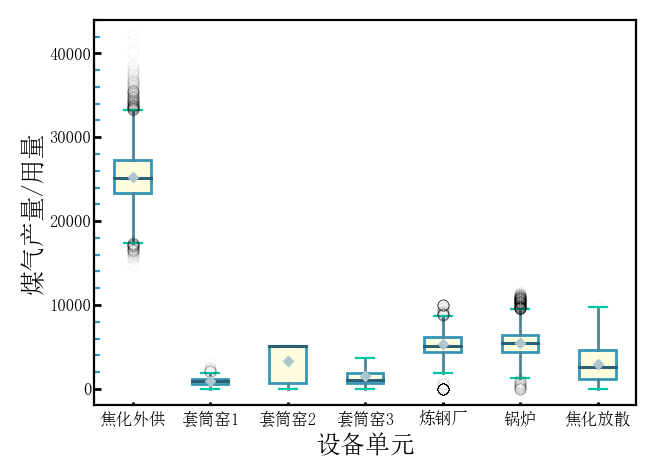

In [20]:
# 将配置重置为默认值
matplotlib.rcdefaults()
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
plt.rcParams.update(config)
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# matplotlib.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['text.usetex'] = True
# matplotlib.rcParams['mathtext.default'] = 'regular'
# plt.rcParams['font.family'] = 'Times New Roman'  # Helvetica Times New Roman

colors = ["#3596B5", "#FEFEDF", "#296073", "#ADC5CF", "#4E8397", "#00C9A7"]  # 0箱体边框、1箱体填充、2中位数线、3均值点、4须、5极值线、

# plt.figure(figsize=(7, 5),dpi=600) # 创建画板
fig, ax1 = plt.subplots(figsize=(3.5, 2.5), dpi=200)
plt.boxplot(ser[0:20000],
            widths=0.47,  # 箱体边框宽度
            labels=ser.columns.values,
            patch_artist=True, boxprops={'color':colors[0], 'facecolor':colors[1], 'linewidth':1},  # 箱体边框颜色；箱体填充色；箱体框线粗细 lightblue
            medianprops=dict(color=colors[2], linewidth=1.1),  # 中位数线颜色、粗细
            showmeans=True, meanprops={'color':colors[3], 'markeredgecolor':colors[3], 'markerfacecolor':colors[3], 'marker':'D','markersize':2},  # 均值点标记
            whiskerprops=dict(color=colors[4], linewidth=1),  # 须的颜色、粗细
            showcaps=True, capprops={'color':colors[5], 'linewidth':0.8},  # 极值线颜色、粗细
            showfliers=True, flierprops={'color':'b', 'linewidth':100, 'markeredgewidth':0.01, 'markersize':4})  # 异常值点设置, sym = '*', 'markeredgewidth':标记点轮廓线粗细, 'markersize':标记点大小

#设置主刻度标签的位置
ax1.yaxis.set_major_locator(MultipleLocator(10000)) #将y轴主刻度标签设置为 的倍数
#设置次刻度标签的位置
ax1.yaxis.set_minor_locator(MultipleLocator(2000)) #将此y轴次刻度标签设置为 的倍数

plt.ylim((-1900, 44000))
# plt.title('Examples of boxplot', fontsize=20)  # 标题，并设定字号大小
plt.tick_params(axis='x', labelsize=6, direction='in', pad=2, length=1, width=1, rotation=0)  # 刻度值大小
plt.tick_params(axis='y', labelsize=6, direction='in', pad=1, length=2.4, width=1)
ax1.tick_params(axis="y", which='minor', direction='in', length=2, width=0.8, color="#3596B5")
ax1.set_xlabel('设备单元', fontsize=9, labelpad=2)
ax1.set_ylabel('煤气产量/用量', fontsize=9, labelpad=2)
# plt.gcf().autofmt_xdate()  # 自动旋转日期标记

# plt.savefig("./output/使用量分布.png", dpi=600)

plt.show()



In [21]:
ser.describe()

焦化外供           套筒窑1           套筒窑2           套筒窑3  \
count  132480.000000  132480.000000  132480.000000  132480.000000   
mean    23684.032127    1410.338285    1667.392239    1350.953907   
std      4032.471117     507.875907    1580.203896     671.545510   
min         0.000013      -0.000015       0.000000       0.000000   
25%     21248.263446    1121.159245     673.435877    1029.313510   
50%     23477.609353    1378.949251    1137.876627    1422.613318   
75%     25857.980849    1832.161504    1385.810445    1573.879126   
max     63691.310322    2951.572548    5139.824150    3692.456738   

                 炼钢厂             锅炉           焦化放散  
count  132480.000000  132480.000000  132480.000000  
mean     4885.601449    4637.217613    1577.690425  
std      1175.047223    1358.747577    2534.085218  
min         2.360017       0.000314       0.000000  
25%      4160.117975    3711.445422     103.000000  
50%      4874.079031    4163.013597     103.000000  
75%      5627.328519    5399.916682    1879.602106  
max     10000.000019   14626.570176   15000.000000

### 工况分割及统计计算

由于数据质量问题对细致的模式判别造成障碍，首先可从整体波动和变化趋势上通过可视化人工筛选粗略完成工况的定性判断。

进一步研究中可通过聚类方法完成这一过程。聚类方法属于无监督学习，虽然能完成分类但分类标准不能很好的控制，需要不断尝试调整特征窗口宽度、统计指标以及预设的种群数量。也许可以通过降维方法减少总的特征数量（现为7个），以提高聚类方法分类清晰度准确度。

也可以将来采用监督学习方法完成工况特征的识别，先通过无监督的聚类方法和人工筛选方法选出一些典型的工况窗口，再通过机器学习实现在更多的数据上进行工况的自动辨别分类。

历史数据中的某些剧烈波动仍要进一步分析研究其属于实际工作状况变化还是数据异常

首先确定用于分析计算的采样窗口宽度及滑移步长，通过合适的窗口宽度来突显设备阶段性工作特征，而选择时间步长相当于间隔抽样，以减小计算量并防止分类的边界过于模糊。

工况类型分类的大体描述：
- 稳定（接受一定范围的小幅波动），并按稳定保持的区间范围进行进一步细分；
- 波动工况（整体稳定并存在整体性的波动）
    - 整体上升
    - 整体下降
    - 上下起伏
- 不稳定工况
    - 波动剧烈，按总体平均值高低进一步细分
- 停产情况
- 异常工况，不参与权重分配，发出检修建议

总体上分析**离散程度**和**趋势变化**，离散程度能反映设备工作的稳定程度，而通过对总体变化趋势判断能知晓对煤气需求量的高低变化。不稳定的的工况或者总体用量呈上升趋势的分类下都应相应提高流量预分配权重，反之可降低分配的权重。分类的关键统计评判指标是对应工况分组数据的方差、趋势走向评价值。

现阶段通过Kmeans聚类以窗口数据均值、样本标准差、极值大小等统计特征为依据实现了自动的工况分类，并输出对应窗口中的流量变化曲线，总体上通过聚类算法能快速的进行自动化分类识别，并在最终分类出的族群中能将异常的工况窗口识别出。但这种无监督方法存在不足，首先是其本身无法明确指定具体的分类标准而只能遵从算法自身的计算规则；其次从不同族群的窗口流量曲线对比中发现，工况分类种群在均值上表现出明显差异，但数据离散情况（对应表征为样本标准差）和变化趋势（通过最小二乘计算窗口数据的斜率）未能表现出明显的分类界限。对于此结果，未来在工况特征的识别分类方面仍有进一步深入研究的空间。暂提出一种有望解决分类边界模糊的探索思路，首先是尝试更替聚类算法或微调优化其算法参数，接着尝试探索另一种思路，即在聚类的初步分类结果上结合人工设立的标准进行统计辨别，再通过监督学习方法实现工况辨别过程的鲁棒性。

#### 截取时间窗口并计算窗口设备数据特征

In [22]:
def compute_trend(*y):
    """
    计算数据的趋势(线性回归求斜率，最小二乘法)
    """
    x = np.arange(len(y[0])) + 1  # 横轴
    y = np.array(y)  # 纵轴
    xymean = np.mean(np.multiply(x, y), axis=1)  # axis=0是batch
    xmeany = np.mean(x) * np.mean(y, axis=1)
    x2mean = np.square(x).mean()
    xmean2 = x.mean()**2
    trend = (xymean-xmeany)/(x2mean - xmean2)
    return trend

In [23]:
ser

焦化外供         套筒窑1         套筒窑2         套筒窑3          炼钢厂  \
0       25467.338037   541.428861  4106.154383  3689.881443  7776.021483   
1       31286.218463   551.789307  4107.876714  3689.791693  7626.024847   
2       27052.133988   554.211750  4109.599045  3689.701942  7751.425194   
3       26449.380349   557.664914  4111.321376  3689.612192  7759.828599   
4       27623.320584   504.572694  4113.043708  3689.522441  7781.008152   
...              ...          ...          ...          ...          ...   
132475  21368.095128  1355.322969   568.961306     0.000005  5618.701037   
132476  21662.745531  1336.454296   560.241123     0.000005  5463.675277   
132477  24639.599501  1284.591330   649.060286     0.000005  5409.511025   
132478  21754.553512  1311.176787   519.891020     0.000005  5347.181945   
132479  21167.228577  1276.500679   490.625415     0.000005  5437.968611   

                 锅炉         焦化放散  
0       6687.897648  3457.050708  
1       6606.700431  5704.971697  
2       6413.561240  5393.052193  
3       6792.389245  3605.506864  
4       6866.979935  4705.525809  
...             ...          ...  
132475  3708.340618   103.000000  
132476  3703.717722   103.000000  
132477  3700.878349   103.000000  
132478  3706.929803   103.000000  
132479  3706.271309   103.000000  

[132480 rows x 7 columns]

In [25]:
win = 30 # 窗口宽度
step = 20 # 窗口移动步幅

# 存储统计特征量 均值、标准差、min、25%、50%、75%、max、最小二乘计算变化趋势
cal1 = np.zeros(((len(ser)-win)//step,8)) # 焦化外供
cal2 = np.zeros(((len(ser)-win)//step,8)) # 套筒窑1
cal3 = np.zeros(((len(ser)-win)//step,8)) # 套筒窑2
cal4 = np.zeros(((len(ser)-win)//step,8)) # 套筒窑3
cal5 = np.zeros(((len(ser)-win)//step,8)) # 炼钢厂
cal6 = np.zeros(((len(ser)-win)//step,8)) # 锅炉
cal7 = np.zeros(((len(ser)-win)//step,8)) # 焦化放散
cal =[cal1,cal2,cal3,cal4,cal5,cal6,cal7]

# 计算统计特征量
for i in range((len(ser)-win)//step):# 遍历的窗口数量
    winSer = ser[i*step:i*step+win] # 截取窗口数据
    for j in range(len(cal)): # 要计算的设备
        cal[j][i] = [np.mean(winSer.values[:,j]),
                   np.std(winSer.values[:,j], ddof = 1), # 计算样本标准差（总体标准差=0）
                   np.min(winSer.values[:,j]),
                   np.percentile(winSer.values[:,j], 25),
                   np.percentile(winSer.values[:,j], 50),
                   np.percentile(winSer.values[:,j], 75),
                   np.max(winSer.values[:,j]),
                   compute_trend(winSer.values[:,j])[0]]
cal1

array([[26177.74025947,  1815.88505675, 22810.365435  , ...,
        27228.781279  , 31286.218463  ,  -115.10217584],
       [26454.22925103,  1642.89113083, 24113.686756  , ...,
        27070.302691  , 30664.625628  ,   106.87802871],
       [28389.78073587,  1499.02162797, 26422.895312  , ...,
        29181.211952  , 32963.624918  ,    78.207899  ],
       ...,
       [20560.52329357,  2285.7497501 , 16144.229948  , ...,
        21933.7091155 , 24520.352915  ,    56.50941056],
       [22268.26116847,  2562.22405472, 17565.539884  , ...,
        24447.52394875, 26446.336584  ,   -67.99847518],
       [21709.9420282 ,  2177.23627031, 17565.539884  , ...,
        23383.60676175, 25874.517484  ,    93.6924284 ]])

In [26]:
winSer

焦化外供         套筒窑1        套筒窑2      套筒窑3          炼钢厂  \
132420  20101.965469  1338.077267  545.616088  0.000007  5491.383346   
132421  19276.121460  1372.079211  612.038822  0.000007  5481.696681   
132422  19745.370893  1377.686967  559.571207  0.000006  5582.142277   
132423  17565.539884  1394.589631  564.967443  0.000006  5543.130300   
132424  17926.216491  1379.358943  541.417904  0.000006  5557.829769   
132425  18651.897016  1405.428155  629.645009  0.000006  5656.695892   
132426  19323.201326  1408.229262  596.009018  0.000006  5634.925456   
132427  20433.532157  1425.348277  580.175401  0.000006  5644.203490   
132428  25874.517484  1394.094212  542.438200  0.000006  5579.944188   
132429  24537.436891  1399.401987  578.001140  0.000006  5572.035833   
132430  23216.726169  1346.550903  544.229520  0.000006  5592.196818   
132431  22752.263397  1361.060171  621.080743  0.000006  5616.106455   
132432  22555.742400  1358.503859  572.764315  0.000006  5527.036954   
132433  22962.281461  1347.307622  595.432860  0.000006  5515.204698   
132434  23090.060932  1320.670105  542.924410  0.000006  5508.123334   
132435  20712.704020  1361.619869  576.287586  0.000006  5467.026832   
132436  20475.041341  1389.446717  605.253300  0.000006  5572.329666   
132437  20230.008485  1460.977703  544.667107  0.000006  5588.424960   
132438  23439.233626  1451.973648  570.887930  0.000006  5559.228349   
132439  24262.838504  1488.117240  564.623751  0.000006  5588.921722   
132440  24213.119075  1485.675187  571.560466  0.000006  5560.126994   
132441  24447.218119  1504.488265  772.387161  0.000006  5493.581764   
132442  24426.248576  1469.105710  549.668769  0.000006  5379.215981   
132443  23564.246993  1450.389152  228.233245  0.000006  5223.110908   
132444  22002.512713  1384.624952  573.946969  0.000006  5276.687595   
132445  21359.059642  1377.833518  588.937150  0.000006  5066.966651   
132446  21010.834035  1331.786323  674.816135  0.000006  4993.824426   
132447  22515.182267  1360.924083  518.040041  0.000006  5047.121338   
132448  20243.980905  1346.309443  588.316530  0.000006  5003.737400   
132449  20383.159115  1355.422615  603.544388  0.000006  5008.826031   

                 锅炉   焦化放散  
132420  3787.974649  103.0  
132421  3810.066548  103.0  
132422  3788.620299  103.0  
132423  3754.116260  103.0  
132424  3735.494462  103.0  
132425  3654.473959  103.0  
132426  3583.514419  103.0  
132427  3632.570629  103.0  
132428  3643.766403  103.0  
132429  3678.951401  103.0  
132430  3716.145364  103.0  
132431  3674.348049  103.0  
132432  3698.165617  103.0  
132433  3698.748269  103.0  
132434  3686.459124  103.0  
132435  3710.098924  103.0  
132436  3713.282676  103.0  
132437  3721.639385  103.0  
132438  3774.540377  103.0  
132439  3758.323539  103.0  
132440  3750.195586  103.0  
132441  3718.168135  103.0  
132442  3723.917952  103.0  
132443  3735.450149  103.0  
132444  3735.704895  103.0  
132445  3739.210119  103.0  
132446  3726.033539  103.0  
132447  3747.507008  103.0  
132448  3757.095051  103.0  
132449  3781.642131  103.0

In [27]:
cal7

array([[3778.43012563, 1297.50012605, 1495.921154  , ..., 5001.57409625,
        5704.971697  ,  -81.26974254],
       [3480.71867133,  898.09807027, 1922.349466  , ..., 4205.45948825,
        5020.930478  ,   -3.92508821],
       [2959.087542  ,  765.5238302 , 1564.159995  , ..., 3256.75650875,
        5020.930478  ,  -40.36716148],
       ...,
       [ 103.        ,    0.        ,  103.        , ...,  103.        ,
         103.        ,    0.        ],
       [ 103.        ,    0.        ,  103.        , ...,  103.        ,
         103.        ,    0.        ],
       [ 103.        ,    0.        ,  103.        , ...,  103.        ,
         103.        ,    0.        ]])

In [28]:
ser[0*step:0*step+win].describe()

焦化外供        套筒窑1         套筒窑2         套筒窑3          炼钢厂  \
count     30.000000   30.000000    30.000000    30.000000    30.000000   
mean   26177.740259  485.459158  4131.128186  3689.825738  7479.223040   
std     1815.885057   30.918719    15.162386     0.246350   318.536042   
min    22810.365435  447.114348  4106.154383  3689.522441  6696.020250   
25%    24596.292985  461.167520  4118.641284  3689.626755  7248.653934   
50%    26515.165067  481.217362  4131.128186  3689.769637  7574.978971   
75%    27228.781279  496.445788  4143.615087  3689.948835  7755.303088   
max    31286.218463  557.664914  4156.101989  3690.504384  7922.296660   

                锅炉         焦化放散  
count    30.000000    30.000000  
mean   6600.676242  3778.430126  
std     209.070667  1297.500126  
min    6059.142543  1495.921154  
25%    6467.462602  2920.437828  
50%    6635.456169  3695.909836  
75%    6757.755183  5001.574096  
max    7011.142285  5704.971697

#### 工况特征聚类

In [29]:
# k-means 聚类
from sklearn.cluster import KMeans

In [30]:
# 存储工况分类结果，采用聚类为每种设备（共7个）划分了5种工况，划分时参考了8种指标,计算这8种指标的统计范围（均值，min,max）暂定三种
res = np.zeros((7,5,8,3))
res[0][0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [31]:
featureNames = ['均值','样本标准差','最小值','25%分位点','50%分位点','75%分位点','最大值','斜率']
# 选择设备
for ii in range(len(cal)):
    X = cal[ii]
    # 定义模型
    model = KMeans(n_clusters=5) # 种群数
    # 模型拟合
    model.fit(X)
    # 为每个示例分配一个集群
    yhat = model.predict(X)
    # 检索唯一群集
    clusters = np.unique(yhat)
    
    # 种群分布图
#     for i in range(X.shape[1]):
#         for j in range(i):
#             # 为每个群集的样本创建散点图
#             for cluster in clusters:
#                 # 获取此群集的示例的行索引
#                 row_ix = np.where(yhat == cluster)
#                 # 创建这些样本的散布
#                 plt.scatter(X[row_ix, i], X[row_ix, j])
#                 plt.xlabel(featureNames[i])
#                 plt.ylabel(featureNames[j])
#             # 绘制散点图
#             plt.savefig("./output/winKmeans/"+str(ii+1)+"/KM"+str(i)+str(j)+".png", dpi=600)
#             plt.show()

    # 输出存储单设备的分类结果
    for cluster in clusters:# 遍历族群类别
        row = np.where(yhat == cluster)# 该类别下的分类序号
        for fea in range(res.shape[2]):
            res[ii][cluster][fea]=[np.mean(X[row][:,fea]),
                                   np.min(X[row][:,fea]),
                                   np.max(X[row][:,fea])] # 计算这8种指标的统计范围（均值，min,max）

In [32]:
res[0][0]

array([[17720.2618204 ,  3388.16218187, 20743.1273583 ],
       [ 1743.8849877 ,   277.1500662 , 13147.87475425],
       [14521.2530603 ,     0.000013  , 18722.766117  ],
       [16592.67040521,     3.6441715 , 21777.84769925],
       [17605.44249357,  1635.8824525 , 23379.85854   ],
       [18739.6995225 ,  6585.5414075 , 24854.4628455 ],
       [21853.02303463,  9511.691465  , 63691.310322  ],
       [    1.90860119,  -663.98130922,   928.04074553]])

In [34]:
# 输出窗口流量曲线比较耗时，选择性执行；
# 聚类的结果不受控制，每次聚类后窗口都有所不同，需要将原 win12345 文件夹清空以存放新的窗口曲线输出结果
# 输出聚类种群的窗口曲线
colors = ['#0081CF','#845EC2','#D65DB1','#FF6F91','#FF9671','#FFC75F','#00C9A7']
ymin = [6000,-200,-700,-300,-700,-700,-800]
ymax = ser.describe().values[-1,:]*1.1
for km in range(len(cal)):# 设备
    for i_ in range(len(yhat)//20):#win数量len(yhat) 数量太多进行一个间隔采样
        i=i_*20
        for j in clusters:#种群
            if yhat[i]==j:

                x=np.array(range(win))  # x = ser.index

                plot1=ser[i*step:i*step+win].values[:,km]
                # 将配置重置为默认值
                plt.rcdefaults()
                config = {
                            "font.family": 'serif',
                            "font.size": 15,
                            "mathtext.fontset": 'stix',
                            "font.serif": ['SimSun'],
                         }
                plt.rcParams.update(config)
                # plt.rcParams['text.usetex'] = True  # 全局开启
                # plt.rcParams['font.family'] = 'Times New Roman'
                plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
                color = ['#6ABAA3', '#47A0FF', '#DC5D8A']#FD702C#837EFF
                # 大小像素
                fig, ax1 = plt.subplots(figsize=(3.5, 2.5))

                # first part
                ax1.plot(x, plot1, label='Wind Speed[m/s]', color=colors[km], alpha=1, linewidth=0.7)  # 输入数据绘制第 1 个 y 轴折线图、设置折线颜色
                ax1.set_ylim(ymin[km],ymax[km])

                # 横轴设置
                plt.xticks(x)
                ax1.tick_params(axis='x', direction='in', pad=2, labelsize=7, length=2.7, width=0.4, rotation=0)  # x 轴刻度值大小
                ax1.set_xlabel('样本点序号', fontsize=10)  # 设置 x 轴标签、字体大小
                # 显示间隔数量
                ax1.xaxis.set_major_locator(plt.MultipleLocator(len(x)/10)) # 函数设置了x轴相邻显示点的间隔

                # 纵轴设置
                ax1.set_ylabel('焦化三期外供煤气流量', fontsize=10)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
                ax1.tick_params(axis='y', direction='in', pad=3, labelsize=7, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
                ax1.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
                #设置主刻度标签的位置
#                 ax1.yaxis.set_major_locator(MultipleLocator(6000)) #将y轴主刻度标签设置为 的倍数
                #设置次刻度标签的位置
#                 ax1.yaxis.set_minor_locator(MultipleLocator(6000/5)) #将此y轴次刻度标签设置为 的倍数
                # 图例 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
                # ax1.legend(loc='upper left', frameon=False, fontsize=5)

                # save and show
                fig.tight_layout()
                plt.savefig('./output/winKmeans/'+str(km+1)+'/win'+str(j+1)+'/win'+str(i)+'.png', dpi=600)
#                 plt.show()
                plt.close(fig)

KeyboardInterrupt: 

<Figure size 350x250 with 0 Axes>

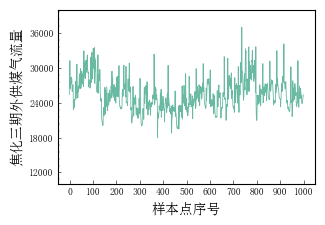

In [36]:

s=0
e=1000
x=ser.index[s:e]  # x = ser.index

plot1=ser.iloc[s:e,[0]]
# 将配置重置为默认值
plt.rcdefaults()
config = {
            "font.family": 'serif',
            "font.size": 15,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
plt.rcParams.update(config)
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
color = ['#6ABAA3', '#47A0FF', '#DC5D8A']#FD702C#837EFF
# 大小像素
fig, ax1 = plt.subplots(figsize=(3.5, 2.5))

# first part
ax1.plot(x, plot1, label='Wind Speed[m/s]', color=color[0], alpha=1, linewidth=0.6)  # 输入数据绘制第 1 个 y 轴折线图、设置折线颜色
ax1.set_ylim(10000,40000)

# 横轴设置
plt.xticks(x)
ax1.tick_params(axis='x', direction='in', pad=2, labelsize=7, length=2.7, width=0.4, rotation=0)  # x 轴刻度值大小
ax1.set_xlabel('样本点序号', fontsize=10)  # 设置 x 轴标签、字体大小
# 显示间隔数量
ax1.xaxis.set_major_locator(plt.MultipleLocator(e/10)) # 函数设置了x轴相邻显示点的间隔

# 纵轴设置
ax1.set_ylabel('焦化三期外供煤气流量', fontsize=10)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
ax1.tick_params(axis='y', direction='in', pad=3, labelsize=7, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
ax1.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
#设置主刻度标签的位置
ax1.yaxis.set_major_locator(MultipleLocator(6000)) #将y轴主刻度标签设置为 的倍数
#设置次刻度标签的位置
ax1.yaxis.set_minor_locator(MultipleLocator(6000/5)) #将此y轴次刻度标签设置为 的倍数
# 图例 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
# ax1.legend(loc='upper left', frameon=False, fontsize=5)

# save and show
fig.tight_layout()
plt.savefig('./output/win.png', dpi=600)
plt.show()
plt.close(fig)

### 不同工况下的权重计算步骤示范

比对实时数据和分割好的历史数据片段统计计算结果各项数值的相似程度并判断从属类别；

按工况读取用于权重计算的相关数据；

考虑按一般的使用量进行权重分配要保证的前提是供大于需，若非此情况，则需要根据先前的优先级对优先级高的设备使用量权重进行优先保障；


#### 获取聚类种群的统计特征

从历史数据计算出的分类参考数据存储在形状为(7,5,8,3)的数组中，4个维度分别对应于7种设备、5种工况、8个参考统计指标、每种统计指标给出的3个范围依据。

In [ ]:
# 好像是表格图片函数
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,

    header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',

    bbox=[0, 0, 1, 1], header_columns=0,

    ax=None, **kwargs):

    if ax is None:

        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])

        fig, ax = plt.subplots(figsize=size)

        ax.axis('off')

        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

        mpl_table.auto_set_font_size(False)

        mpl_table.set_fontsize(font_size)

        for k, cell in six.iteritems(mpl_table._cells):

            cell.set_edgecolor(edge_color)

            if k[0] == 0 or k[1] < header_columns:

                cell.set_text_props(weight='bold', color='w')

                cell.set_facecolor(header_color)
    
            else:

                cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

    return ax


In [37]:
serNames

['焦化外供', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '焦化放散']

In [81]:
# 焦化外供的5种工况
pd.DataFrame(res[0,0], index=list(['均值','std','min','25%','50%','75%','max','趋势']), columns=list(['mean','min','max']))

mean          min           max
均值   17720.261820  3388.162182  20743.127358
std   1743.884988   277.150066  13147.874754
min  14521.253060     0.000013  18722.766117
25%  16592.670405     3.644172  21777.847699
50%  17605.442494  1635.882452  23379.858540
75%  18739.699522  6585.541407  24854.462845
max  21853.023035  9511.691465  63691.310322
趋势       1.908601  -663.981309    928.040746

C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


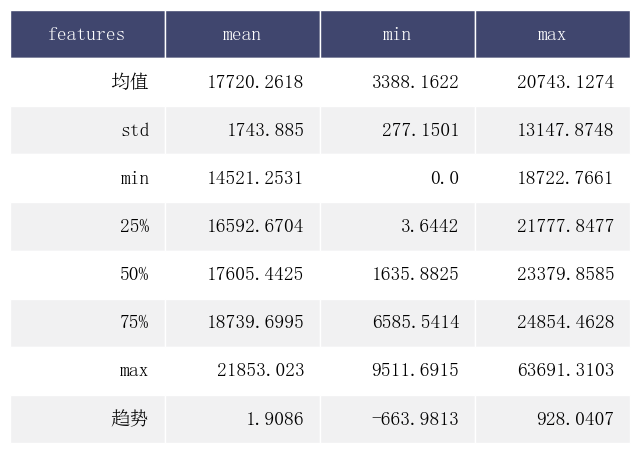

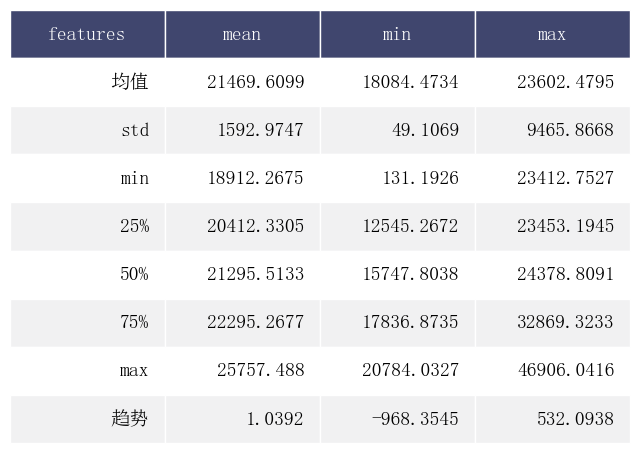

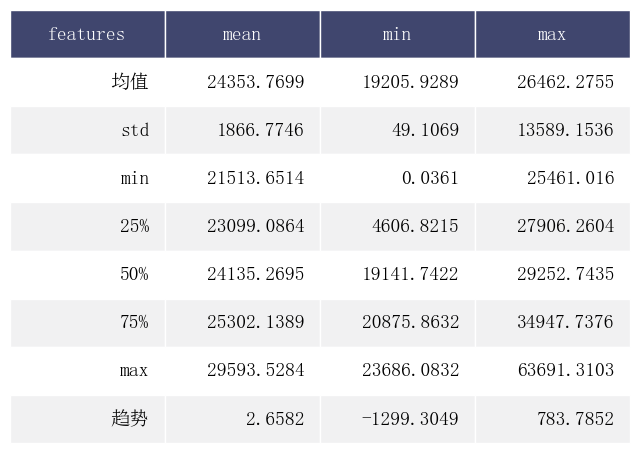

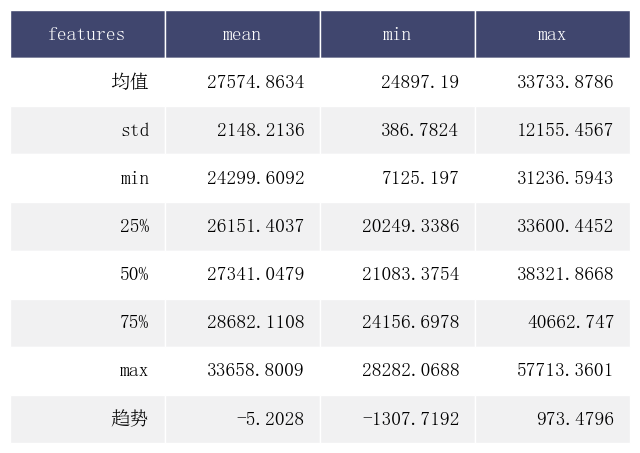

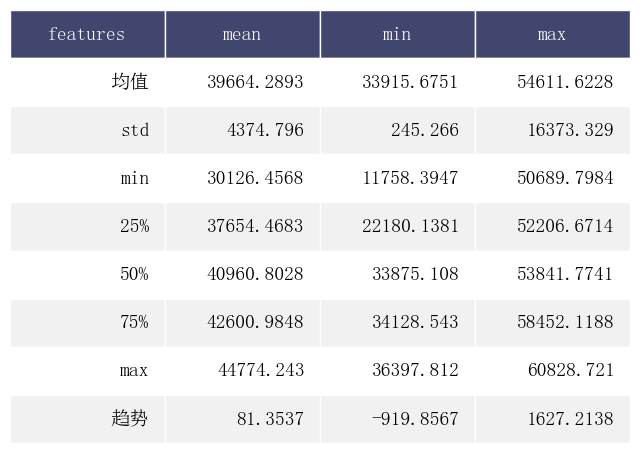

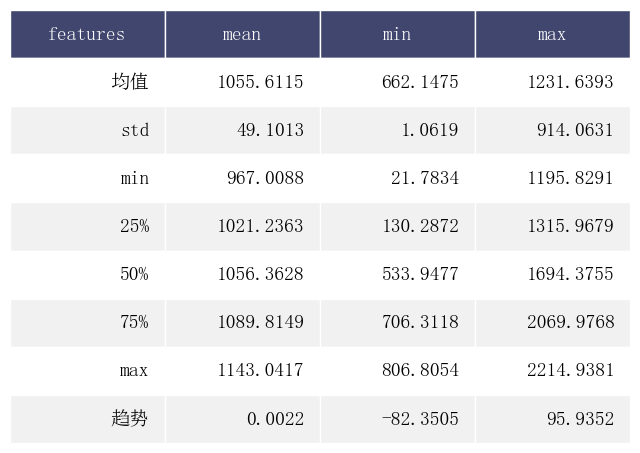

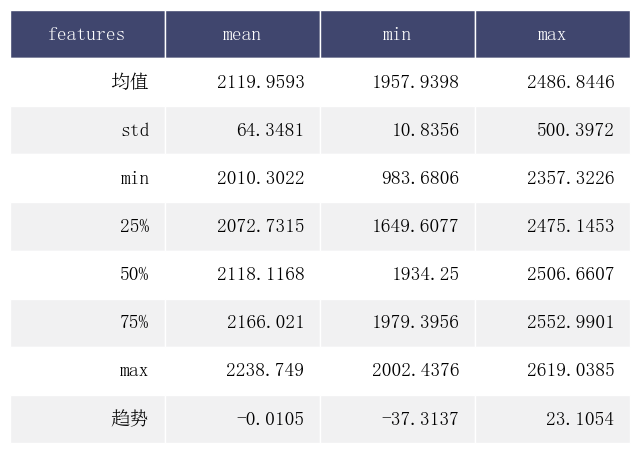

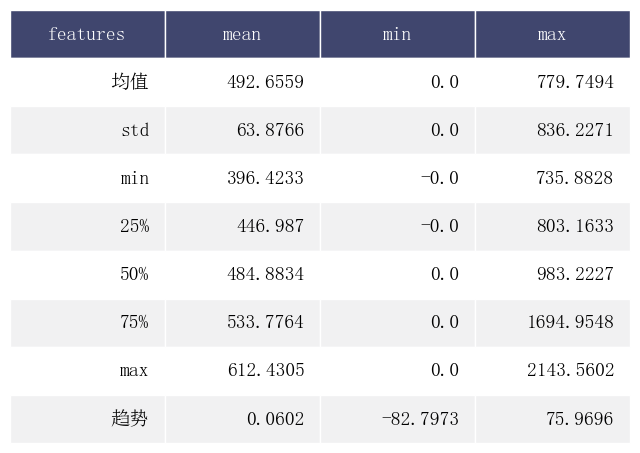

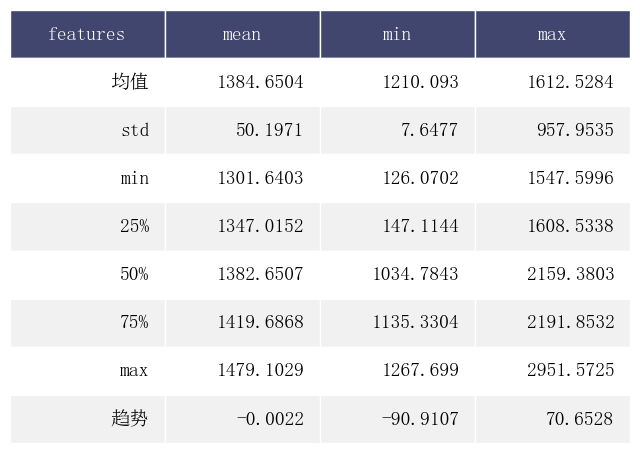

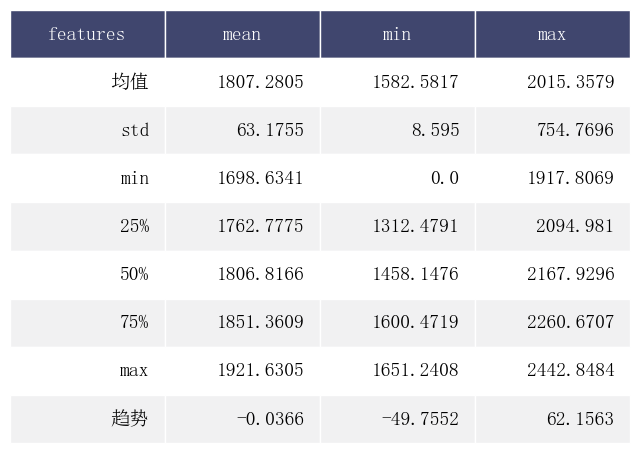

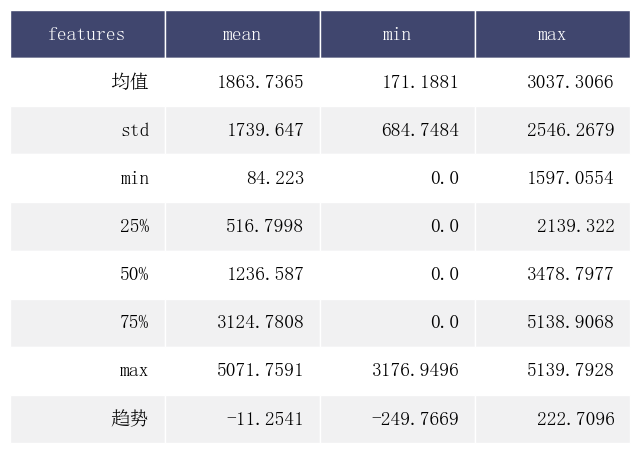

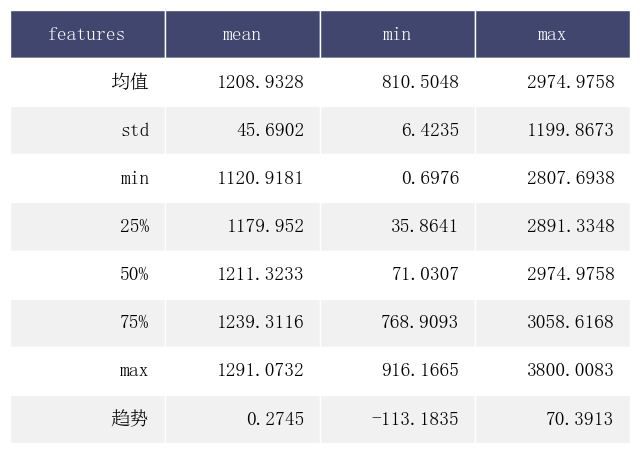

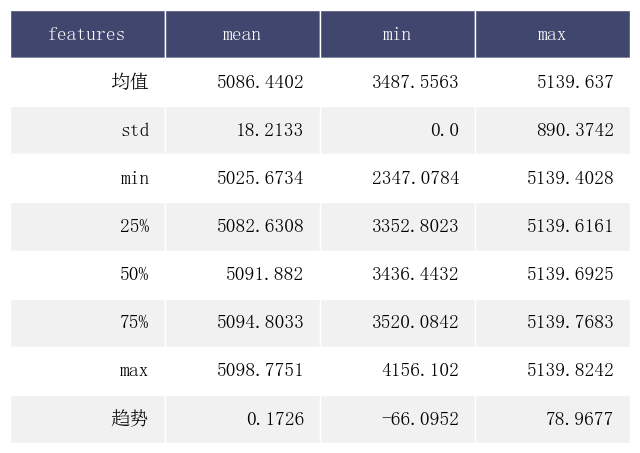

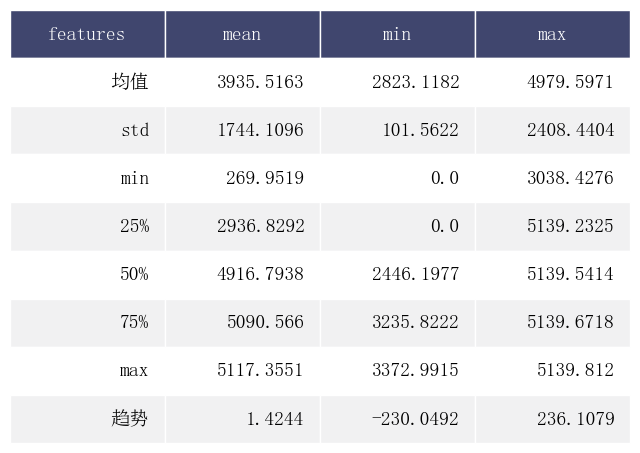

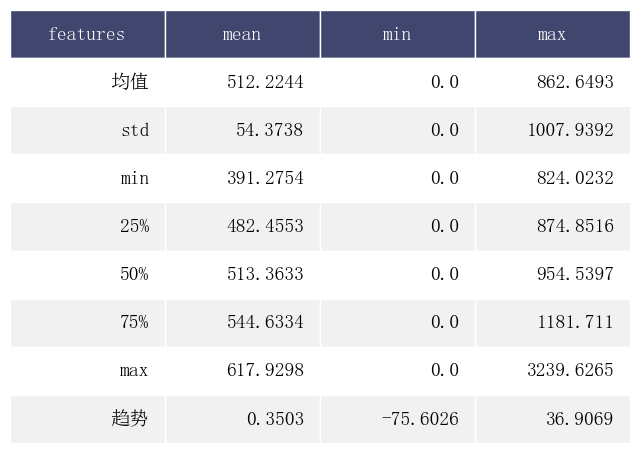

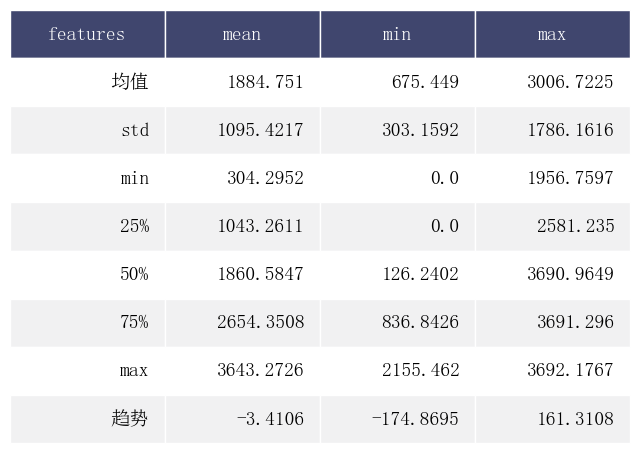

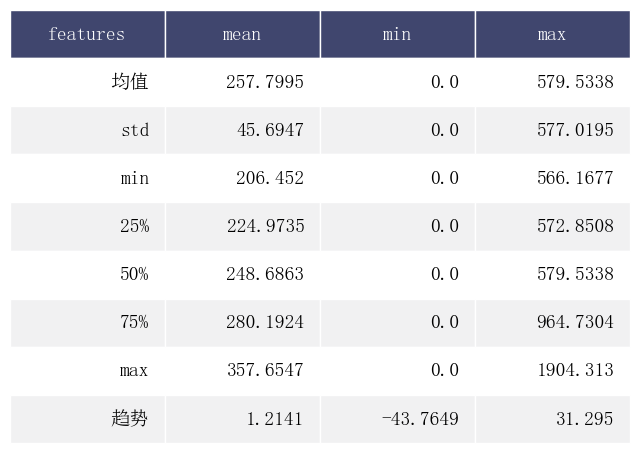

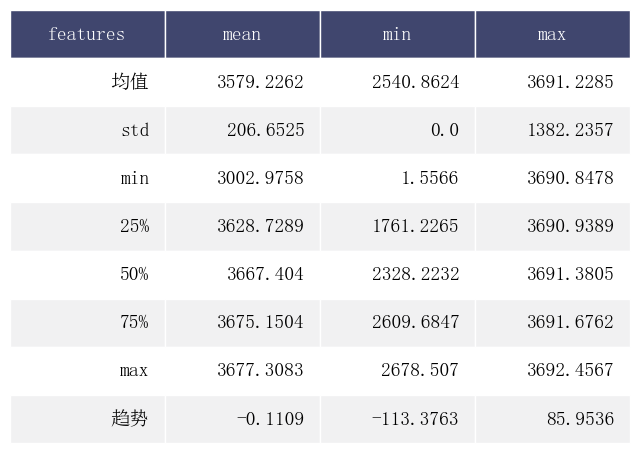

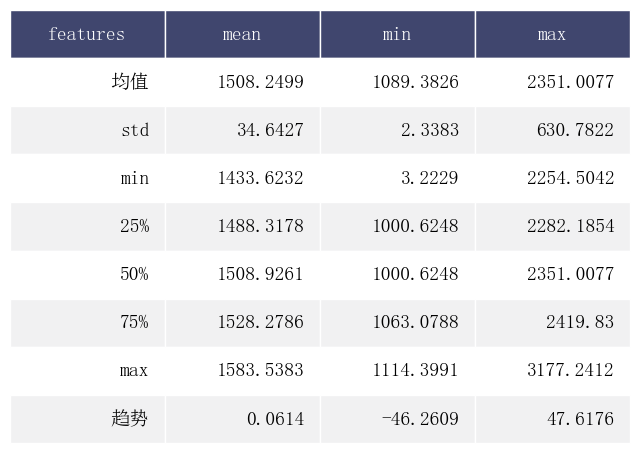

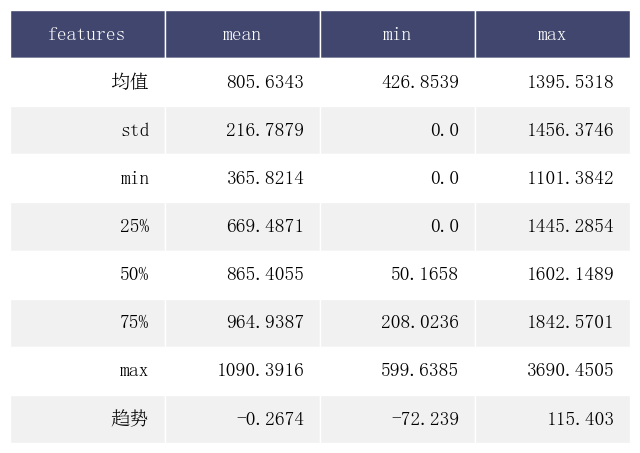

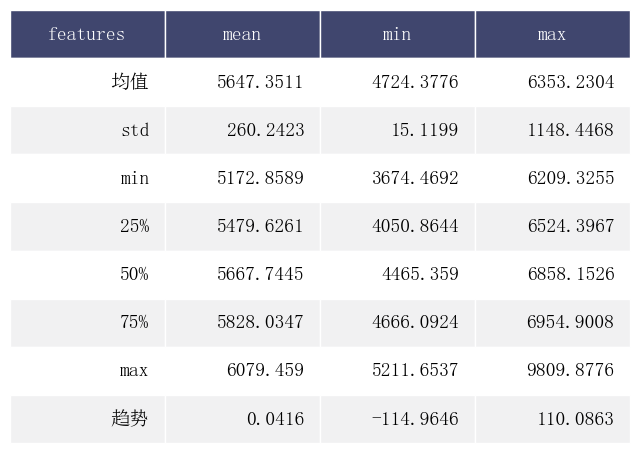

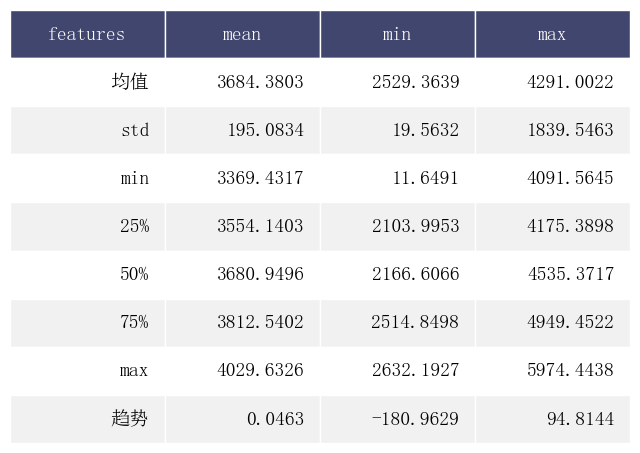

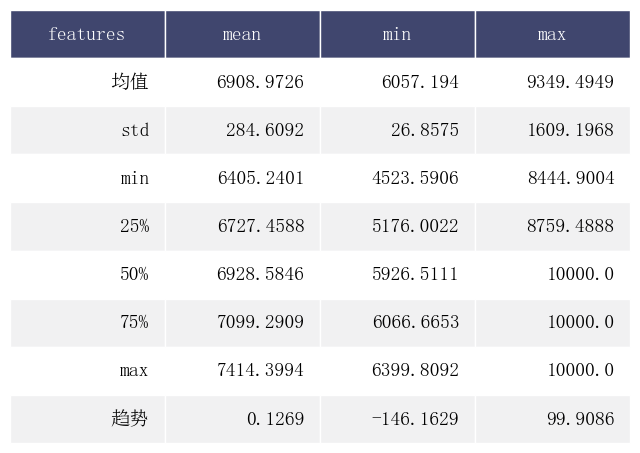

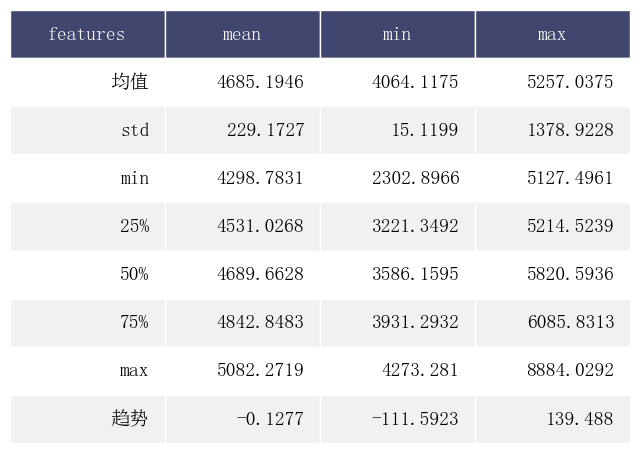

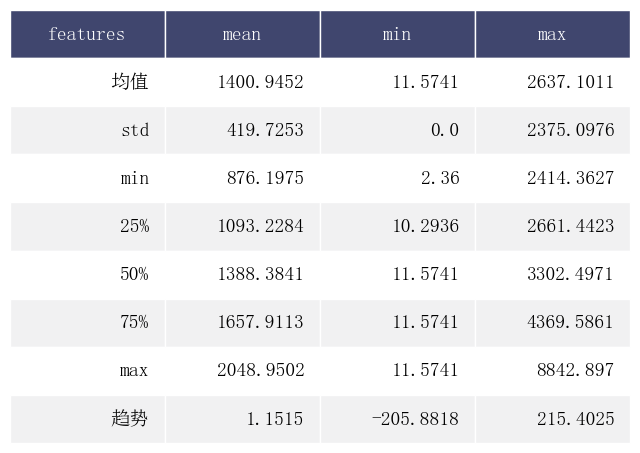

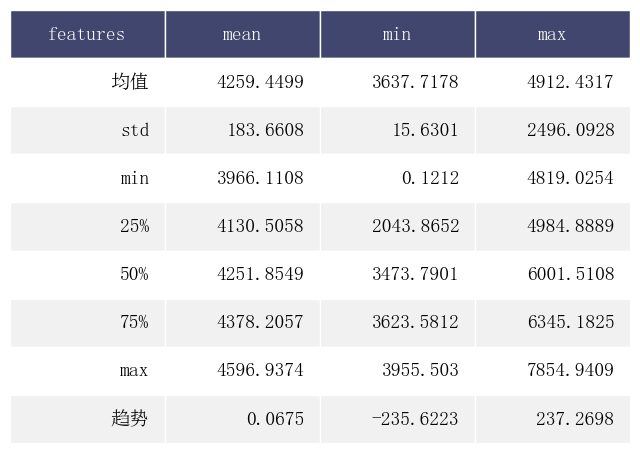

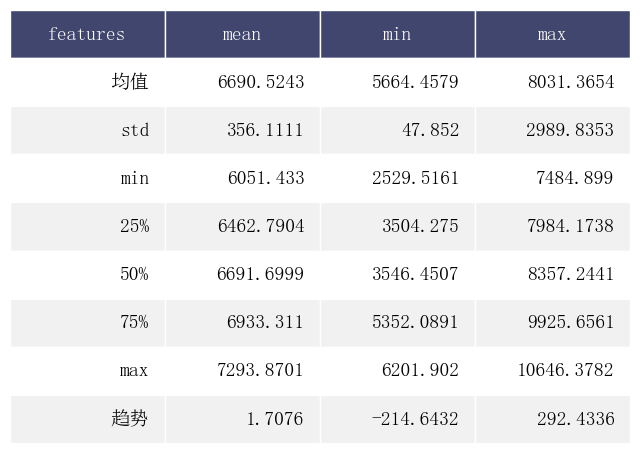

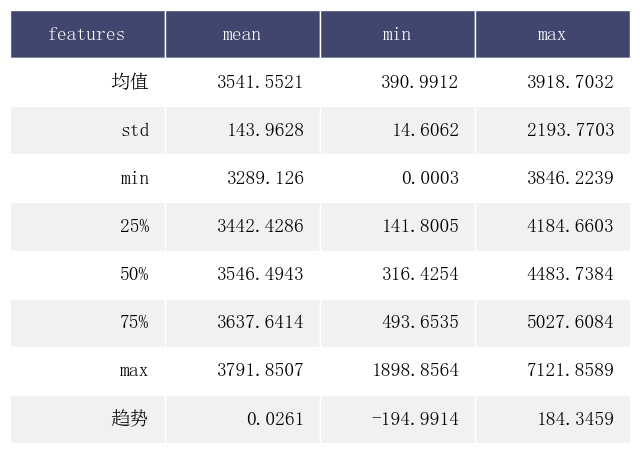

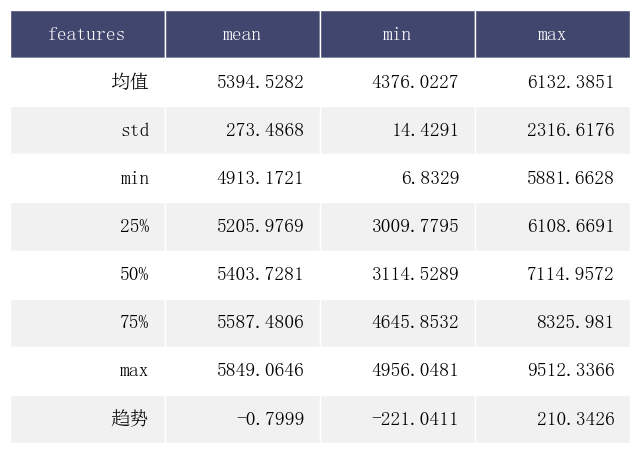

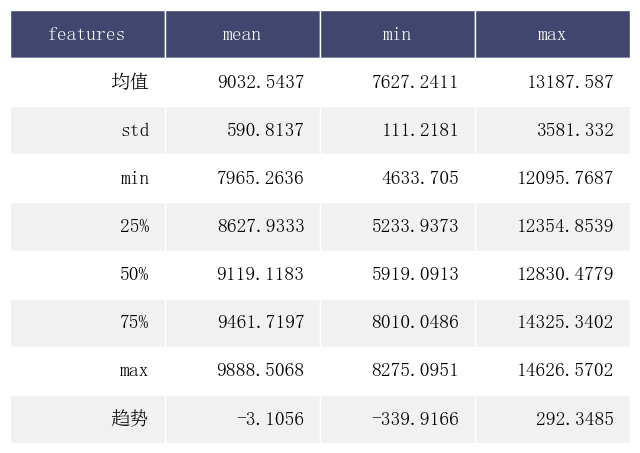

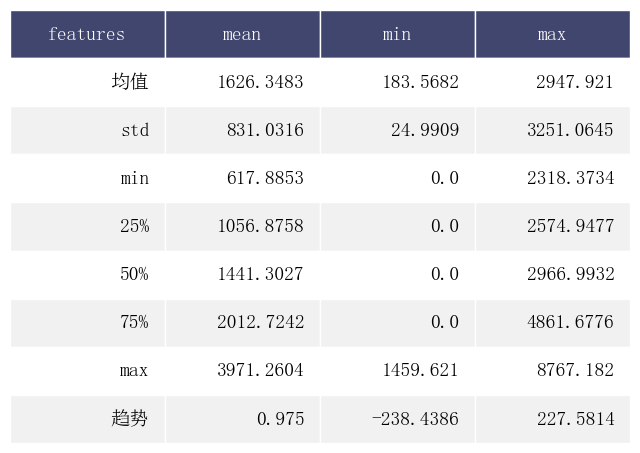

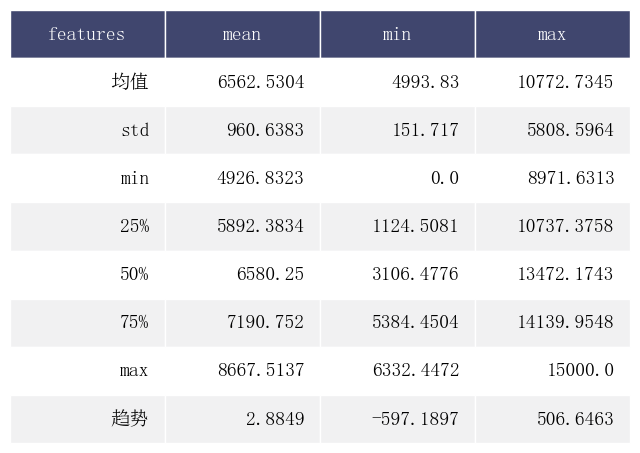

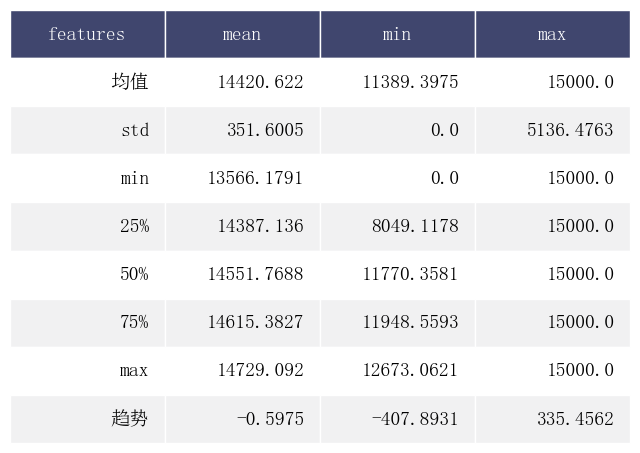

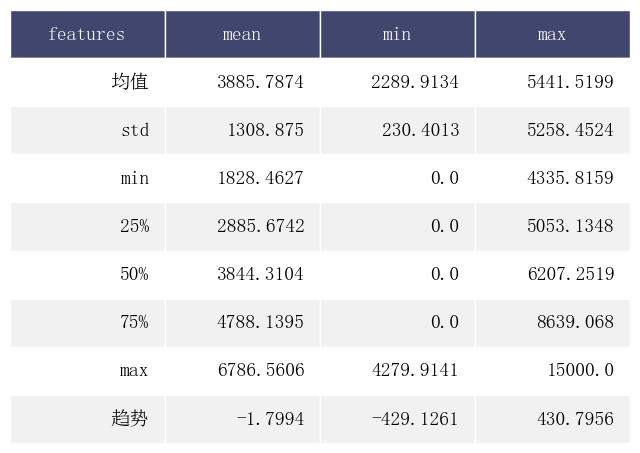

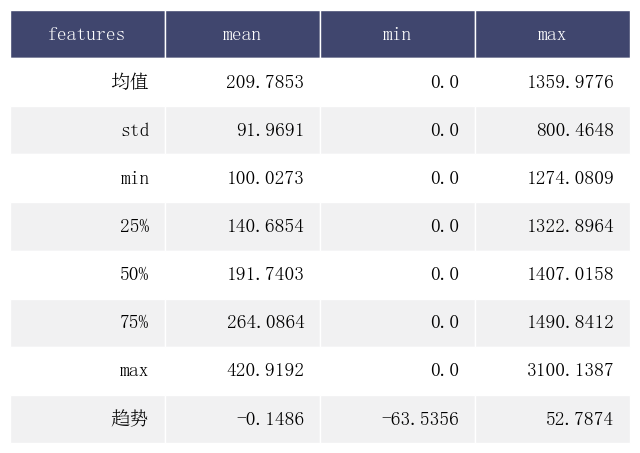

In [109]:
for j in range(7):
    for i in range(5):
        h = res[j,i]
        h = np.around(h, decimals=4)
        df = pd.DataFrame()
        df['features'] = ['均值','std','min','25%','50%','75%','max','趋势']
        df['mean'] = h[:,0]
        df['min'] = h[:,1]
        df['max'] = h[:,2]
        render_mpl_table(df, header_columns=0, col_width=2.0)
        plt.savefig('./output/winKmeans/'+str(j+1)+'/state'+str(i),dpi=500)

In [80]:
pd.DataFrame(res[0,1], index=list(['均值','std','min','25%','50%','75%','max','趋势']), columns=list(['mean','min','max']))

mean           min           max
均值   21469.609884  18084.473372  23602.479478
std   1592.974731     49.106944   9465.866787
min  18912.267545    131.192554  23412.752705
25%  20412.330505  12545.267175  23453.194466
50%  21295.513320  15747.803840  24378.809138
75%  22295.267714  17836.873488  32869.323259
max  25757.487977  20784.032666  46906.041580
趋势       1.039174   -968.354489    532.093760

In [40]:
pd.DataFrame(res[0,2], index=list(['均值','std','min','25%','50%','75%','max','趋势']), columns=list(['mean','min','max']))

mean           min           max
均值   24353.769945  19205.928875  26462.275521
std   1866.774636     49.106944  13589.153566
min  21513.651444      0.036132  25461.016045
25%  23099.086376   4606.821488  27906.260389
50%  24135.269452  19141.742182  29252.743460
75%  25302.138883  20875.863206  34947.737567
max  29593.528416  23686.083230  63691.310322
趋势       2.658153  -1299.304871    783.785167

In [41]:
pd.DataFrame(res[0,3], index=list(['均值','std','min','25%','50%','75%','max','趋势']), columns=list(['mean','min','max']))

mean           min           max
均值   27574.863362  24897.190047  33733.878566
std   2148.213621    386.782442  12155.456732
min  24299.609156   7125.196985  31236.594337
25%  26151.403662  20249.338612  33600.445235
50%  27341.047888  21083.375357  38321.866756
75%  28682.110755  24156.697805  40662.746980
max  33658.800935  28282.068839  57713.360051
趋势      -5.202800  -1307.719160    973.479576

In [42]:
pd.DataFrame(res[0,4], index=list(['均值','std','min','25%','50%','75%','max','趋势']), columns=list(['mean','min','max']))

mean           min           max
均值   39664.289340  33915.675098  54611.622756
std   4374.796047    245.265982  16373.329022
min  30126.456775  11758.394734  50689.798411
25%  37654.468336  22180.138078  52206.671398
50%  40960.802789  33875.108004  53841.774088
75%  42600.984798  34128.542954  58452.118839
max  44774.242989  36397.812008  60828.721001
趋势      81.353675   -919.856683   1627.213813

#### 进行权重计算和流量预分配

这里由于设备数据不全，采用现有数据示范的计算方案仅在理论上具有指导意义，实际中的开发利用必须应用匹配的生产数据。已有数据中的煤气生产端采用的是焦化三期外供煤气流量，而消耗侧流量数据单元为'套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉'，由于数据不足现有的流量产销侧数据加上放散量在供销关系不满足守恒。

In [43]:
# 以所有设备的第一种工况为例
for i in range(7):
    print(res[i,0,0,0])

17720.26182039567
1055.6114874586478
1863.7365334587305
1884.7510495523811
5647.351123318677
4259.44986954519
1626.348337407695


In [44]:
res[1:6,0,0,0]

array([1055.61148746, 1863.73653346, 1884.75104955, 5647.35112332,
       4259.44986955])

In [45]:
def calPriority(a):
    result = np.zeros(len(a))
    for i in range(len(a)):
        result[i] = a[i]/np.sum(a)
    return(result)
q = calPriority(res[1:6,0,0,0])
q

array([0.0717571 , 0.12669086, 0.12811936, 0.38388889, 0.2895438 ])

In [46]:
pd.DataFrame([q], index=list(['权重']), columns=list(['套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉']))

套筒窑1      套筒窑2      套筒窑3       炼钢厂        锅炉
权重  0.071757  0.126691  0.128119  0.383889  0.289544

## 时间关联度优先级定制

这里先分析单个设备流量数据的时间关联性，再分析两个时间序列之间的相关性。

### 时间滞后相关性(主要体现了单一设备流量是否连续，是否有个较稳定工作范围)

In [47]:
ser

焦化外供         套筒窑1         套筒窑2         套筒窑3          炼钢厂  \
0       25467.338037   541.428861  4106.154383  3689.881443  7776.021483   
1       31286.218463   551.789307  4107.876714  3689.791693  7626.024847   
2       27052.133988   554.211750  4109.599045  3689.701942  7751.425194   
3       26449.380349   557.664914  4111.321376  3689.612192  7759.828599   
4       27623.320584   504.572694  4113.043708  3689.522441  7781.008152   
...              ...          ...          ...          ...          ...   
132475  21368.095128  1355.322969   568.961306     0.000005  5618.701037   
132476  21662.745531  1336.454296   560.241123     0.000005  5463.675277   
132477  24639.599501  1284.591330   649.060286     0.000005  5409.511025   
132478  21754.553512  1311.176787   519.891020     0.000005  5347.181945   
132479  21167.228577  1276.500679   490.625415     0.000005  5437.968611   

                 锅炉         焦化放散  
0       6687.897648  3457.050708  
1       6606.700431  5704.971697  
2       6413.561240  5393.052193  
3       6792.389245  3605.506864  
4       6866.979935  4705.525809  
...             ...          ...  
132475  3708.340618   103.000000  
132476  3703.717722   103.000000  
132477  3700.878349   103.000000  
132478  3706.929803   103.000000  
132479  3706.271309   103.000000  

[132480 rows x 7 columns]

In [48]:
ser.values[:,0]

array([25467.338037, 31286.218463, 27052.133988, ..., 24639.599501,
       21754.553512, 21167.228577])

In [49]:
serNames

['焦化外供', '套筒窑1', '套筒窑2', '套筒窑3', '炼钢厂', '锅炉', '焦化放散']

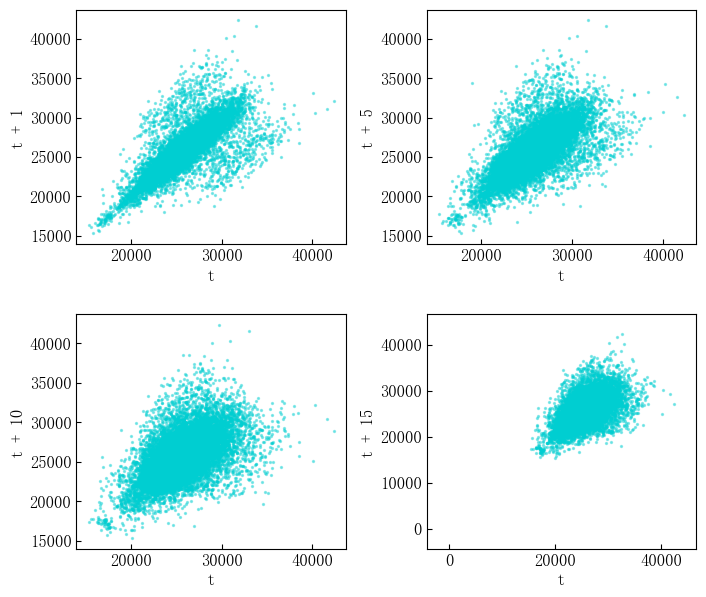

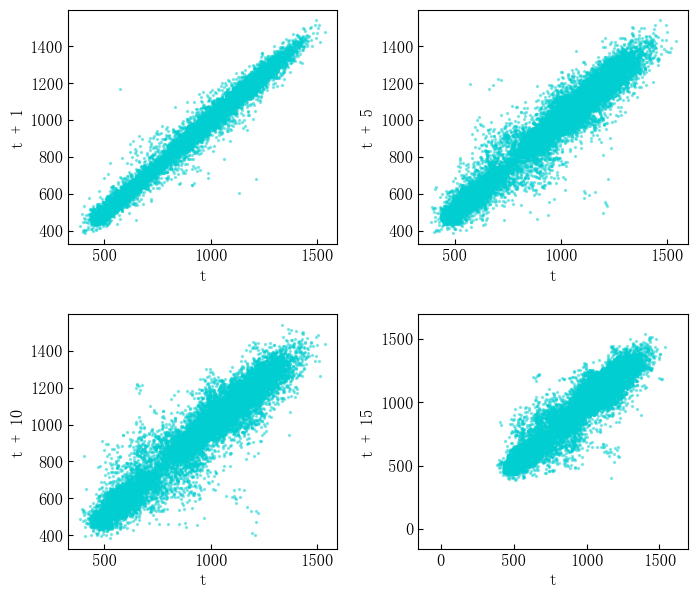

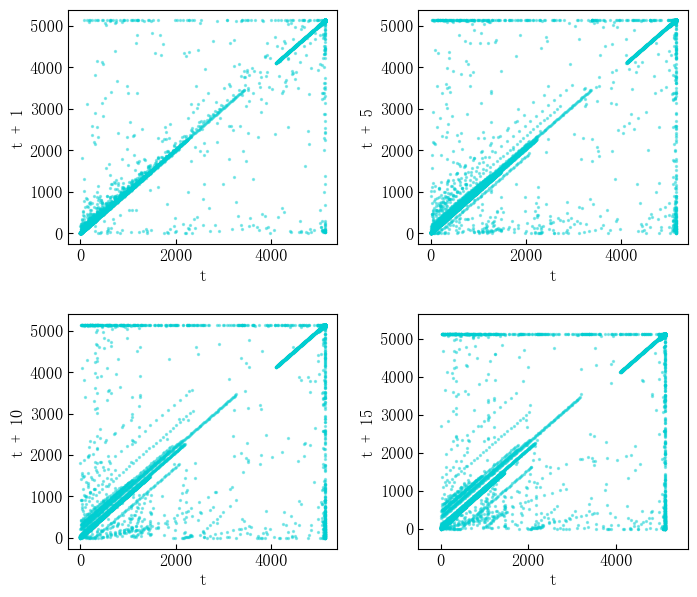

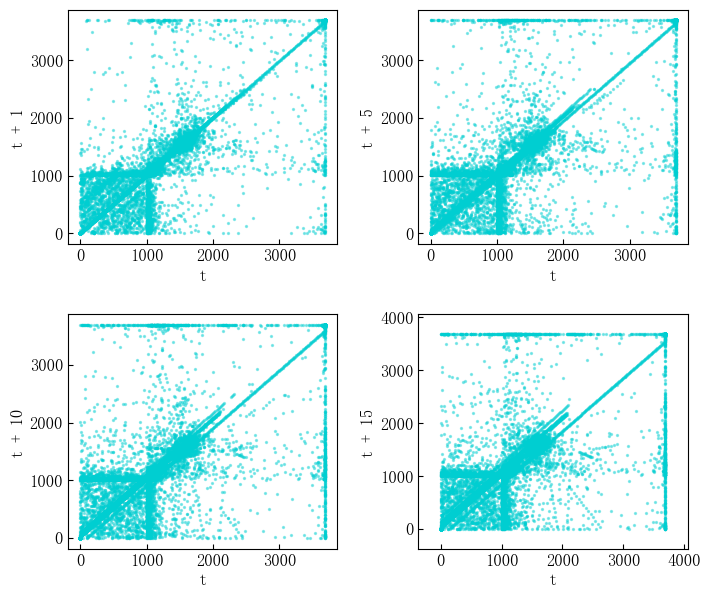

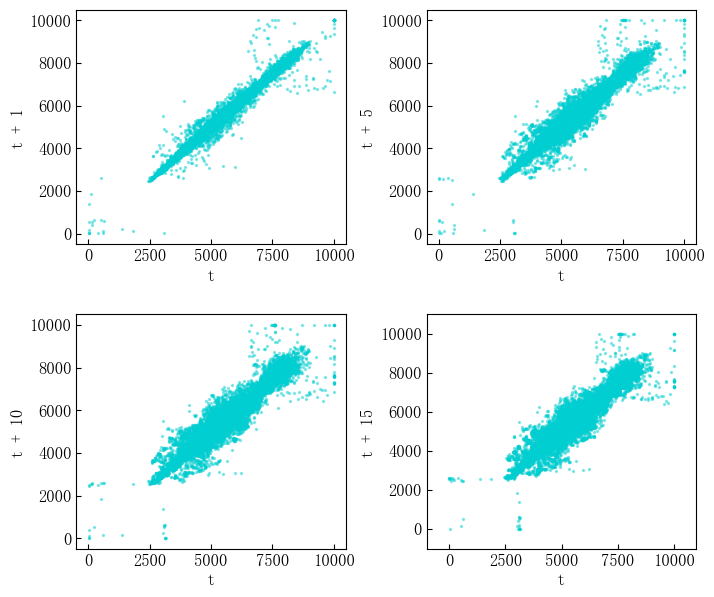

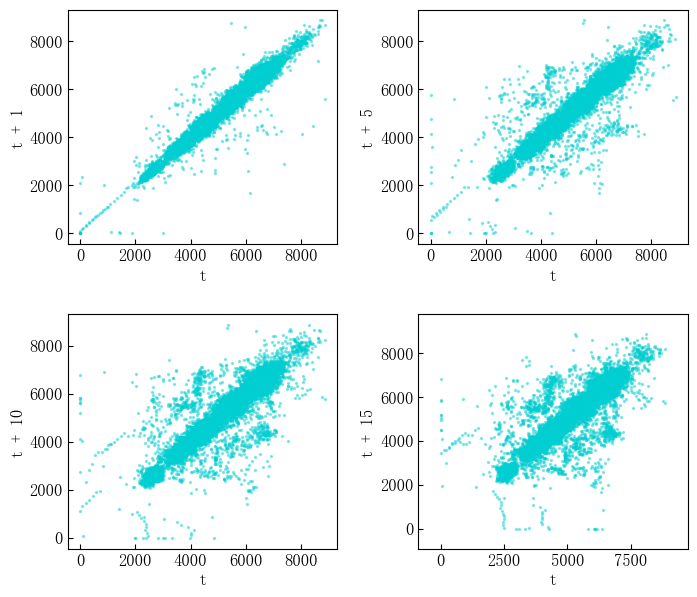

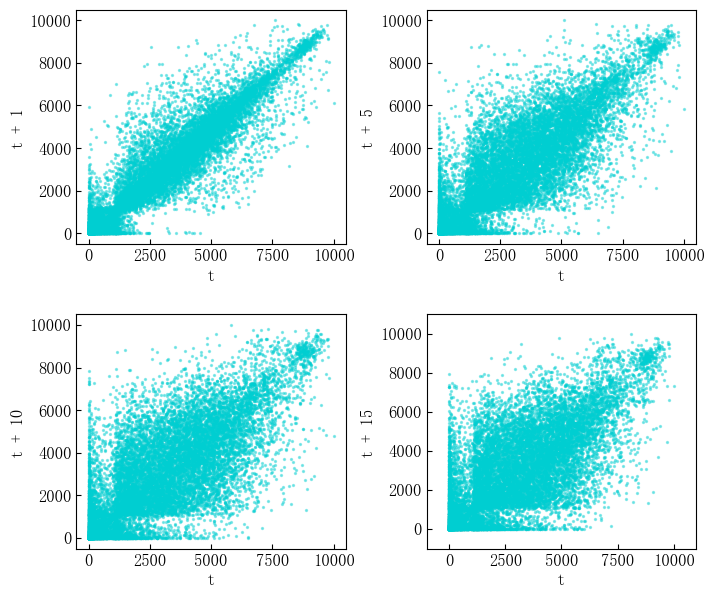

In [60]:


colors = ['#DC143C', '#00CED1']  #点的颜色

a=1
b=5
c=10
d=15
t=20
for i in range(len(serNames)):
    x = ser.values[:,i][0:15000]
    yy1 = -np.max(x)*0.1
    yy2 = np.max(x)*1.1
    plt.rcdefaults()
    config = {
                "font.family": 'serif',
                "font.size": 12,
                "mathtext.fontset": 'stix',
                "font.serif": ['SimSun'],
             }
    plt.rcParams.update(config)
    # plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    fig, axes = plt.subplots(2,2,figsize=(8,7), dpi= 100)

    plt.xlim(xmin = yy1,xmax = yy2)
    plt.ylim(ymin = yy1,ymax = yy2)

    plt.subplot(221)
    area = 2  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(a))
    plt.scatter(x[0:len(x)-t], x[a:len(x)-(t-a)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplot(222)
    # area = 8  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(b))
    # plt.xlim(xmin = 0,xmax = yy)
    # plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-t], x[b:len(x)-(t-b)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplot(223)
    # area = 8  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(c))
    # plt.xlim(xmin = 0,xmax = yy)
    # plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-t], x[c:len(x)-(t-c)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplot(224)
    # area = 8  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(d))
    # plt.xlim(xmin = 0,xmax = yy)
    # plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-t], x[d:len(x)-(t-d)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.savefig(r'./output/time/1/delay_'+serNames[i]+'.png', dpi=600)
    plt.show()

### 不同设备流量变化的时间相关性

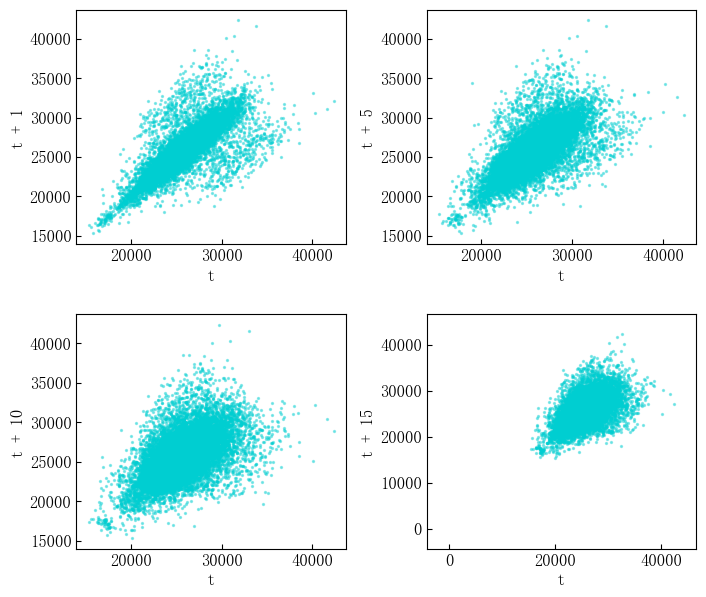

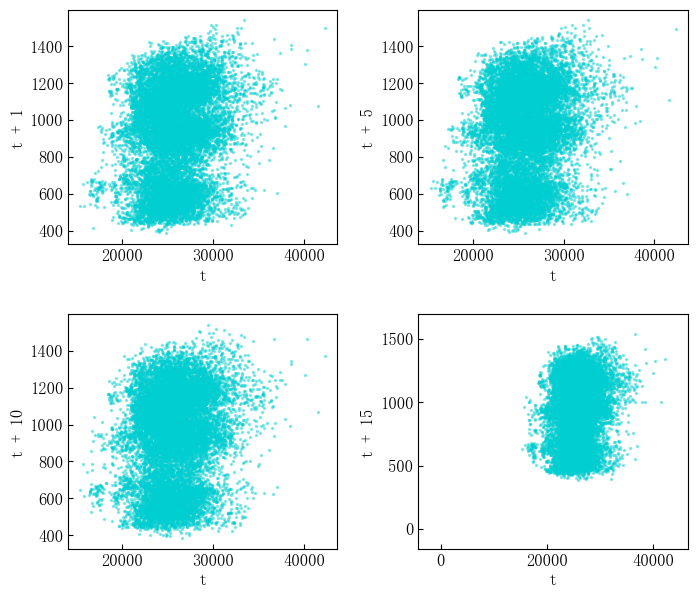

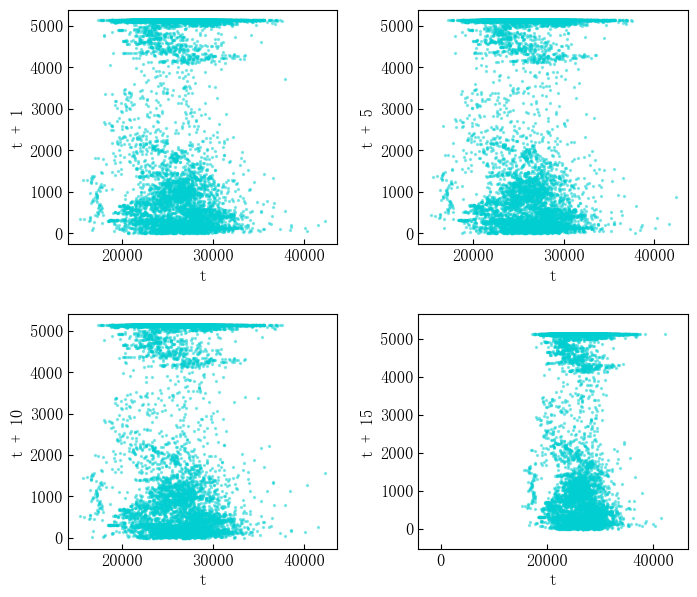

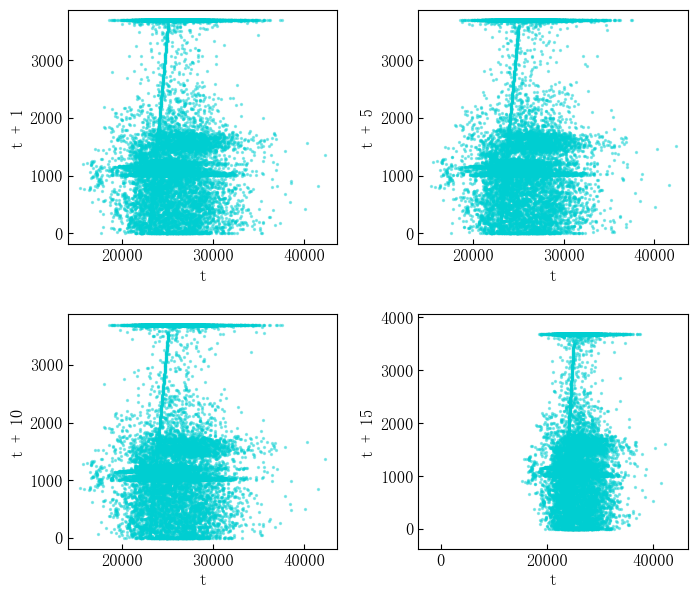

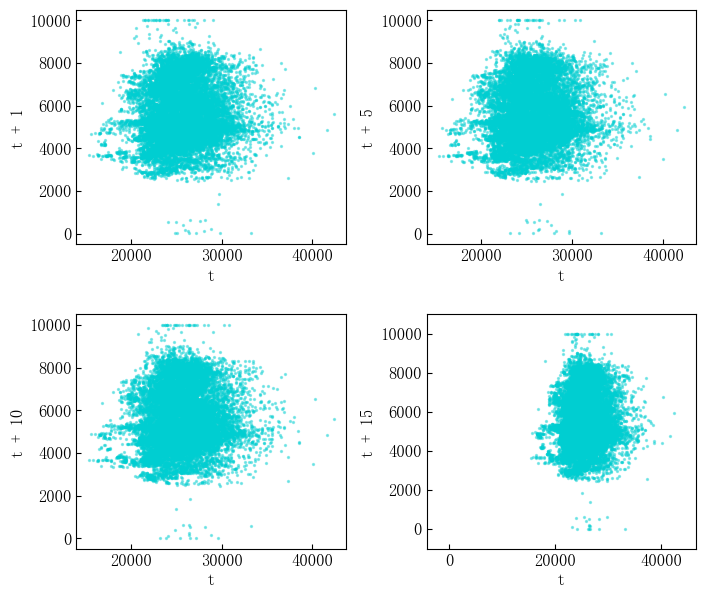

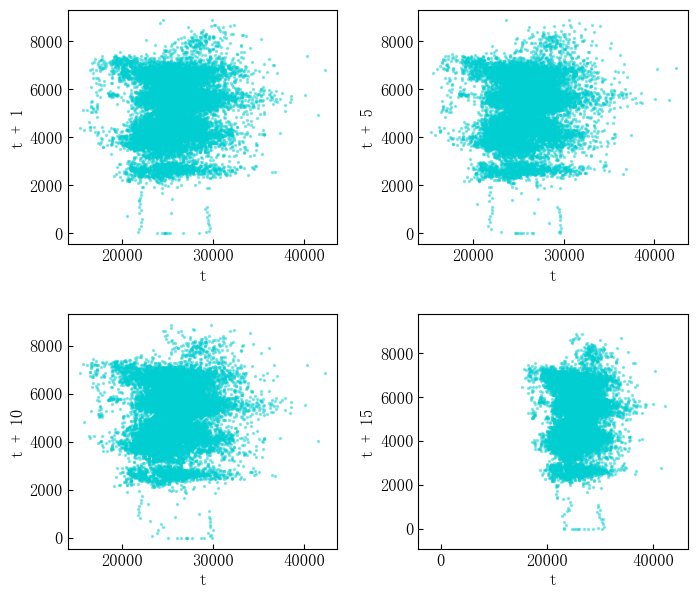

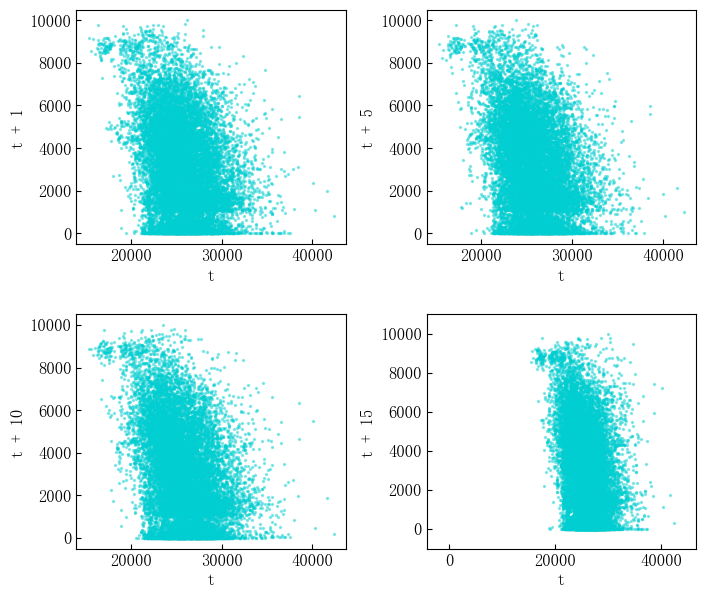

In [67]:


colors = ['#DC143C', '#00CED1']  #点的颜色

a=1
b=5
c=10
d=15
t=20
for i in range(len(serNames)):
    x1 = ser.values[:,0][0:15000]
    x2 = ser.values[:,i][0:15000]
    yy1 = -np.max(x1)*0.1
    yy2 = np.max(x1)*1.1
    yy11 = -np.max(x2)*0.1
    yy22 = np.max(x2)*1.1
    plt.rcdefaults()
    config = {
                "font.family": 'serif',
                "font.size": 12,
                "mathtext.fontset": 'stix',
                "font.serif": ['SimSun'],
             }
    plt.rcParams.update(config)
    # plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    fig, axes = plt.subplots(2,2,figsize=(8,7), dpi= 100)

    plt.xlim(xmin = yy1,xmax = yy2)
    plt.ylim(ymin = yy11,ymax = yy22)

    plt.subplot(221)
    area = 2  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(a))
    plt.scatter(x1[0:len(x)-t], x2[a:len(x)-(t-a)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplot(222)
    # area = 8  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(b))
    # plt.xlim(xmin = 0,xmax = yy)
    # plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x1[0:len(x)-t], x2[b:len(x)-(t-b)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplot(223)
    # area = 8  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(c))
    # plt.xlim(xmin = 0,xmax = yy)
    # plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x1[0:len(x)-t], x2[c:len(x)-(t-c)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplot(224)
    # area = 8  # 点面积 
    plt.xlabel("t")
    plt.ylabel("t + "+str(d))
    # plt.xlim(xmin = 0,xmax = yy)
    # plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x1[0:len(x)-t], x2[d:len(x)-(t-d)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.savefig(r'./output/time/2/delay_'+serNames[0]+'_'+serNames[i]+'.png', dpi=600)
    plt.show()

### 多窗口的时间相关性

TLCC 时间滞后互相关 —— 评估信号动态性

时间滞后互相关（TLCC）可以定义两个信号之间的方向性，例如引导-追随关系，在这种关系中，引导信号会初始化一个响应，追随信号则重复它。还有一些其他方法可以探查这类关系，包括格兰杰因果，它常用于经济学，但是要注意这些仍然不一定能反映真正的因果关系。但是，通过查看互相关，我们还是可以提取出哪个信号首先出现的信息。

TLCC 是通过逐步移动一个时间序列向量（红色线）并反复计算两个信号间的相关性而测量得到的。如果相关性的峰值位于中心（offset=0），那就意味着两个时间序列在此时相关性最高。但是，如果一个信号在引导另一个信号，相关性的峰值就可能位于不同的坐标值上。



In [68]:
ser

焦化外供         套筒窑1         套筒窑2         套筒窑3          炼钢厂  \
0       25467.338037   541.428861  4106.154383  3689.881443  7776.021483   
1       31286.218463   551.789307  4107.876714  3689.791693  7626.024847   
2       27052.133988   554.211750  4109.599045  3689.701942  7751.425194   
3       26449.380349   557.664914  4111.321376  3689.612192  7759.828599   
4       27623.320584   504.572694  4113.043708  3689.522441  7781.008152   
...              ...          ...          ...          ...          ...   
132475  21368.095128  1355.322969   568.961306     0.000005  5618.701037   
132476  21662.745531  1336.454296   560.241123     0.000005  5463.675277   
132477  24639.599501  1284.591330   649.060286     0.000005  5409.511025   
132478  21754.553512  1311.176787   519.891020     0.000005  5347.181945   
132479  21167.228577  1276.500679   490.625415     0.000005  5437.968611   

                 锅炉         焦化放散  
0       6687.897648  3457.050708  
1       6606.700431  5704.971697  
2       6413.561240  5393.052193  
3       6792.389245  3605.506864  
4       6866.979935  4705.525809  
...             ...          ...  
132475  3708.340618   103.000000  
132476  3703.717722   103.000000  
132477  3700.878349   103.000000  
132478  3706.929803   103.000000  
132479  3706.271309   103.000000  

[132480 rows x 7 columns]

In [28]:
fgh = ser['焦化外供'][7000:8000]
fgh

7000    23588.996449
7001    23785.979557
7002    32030.875411
7003    25604.025736
7004    24934.881550
            ...     
7995    28905.873965
7996    34696.336778
7997    27958.419300
7998    29004.459650
7999    28859.353838
Name: 焦化外供, Length: 1000, dtype: float64

In [29]:
dfg = ser.iloc[7000:8000,2]
dfg

7000    5138.332505
7001    5137.937827
7002    5137.783596
7003    5138.373403
7004    5138.325270
           ...     
7995    5034.451447
7996    5033.603738
7997    5032.756030
7998    5031.908321
7999    5031.060613
Name: 套筒窑2, Length: 1000, dtype: float64

In [9]:
import scipy.stats as stats

In [31]:
# 依次计算所有时间窗口与其它变量前后窗口的皮尔逊相关系数
def crosscorr(datax, datay):
    win = 30
    horizon = 30 #前面窗口数，
    step1 = 1 #左侧窗口滑移步长
    step2 = 1#右侧向前后的窗口阶跃步长
    
    length = (len(datax)-(horizon*2*step2+win))//step1
    ress = np.zeros((length,horizon*2+1))
    
    for j in range(length):
        for i in range(horizon*2+1):
            mid = j*step1+horizon*step2# 中间窗起始位置
            sta = mid-horizon*step2+i*step2# 互相关最上面窗口起始位置//////////
            x = datax[mid:mid+win]
            y = datay[sta:sta+win]
#             print(x)
#             print(y)
            ress[j,i] = stats.pearsonr(x,y)[0]#x.corr(y)
    return ress

In [32]:
rs = crosscorr(fgh.values,dfg.values)
rs

C:\bigCong\env\py37_1_tf\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


array([[-0.12589966, -0.19333905, -0.04477954, ...,  0.03446445,
         0.05614986,  0.00042308],
       [-0.14636781, -0.20249334, -0.06559053, ...,  0.07125083,
         0.09015109,  0.0146908 ],
       [-0.15679659, -0.23001792, -0.04790391, ...,  0.07392059,
         0.10440868,  0.01585681],
       ...,
       [-0.07663223, -0.07663222, -0.07663223, ..., -0.07663224,
        -0.07663223, -0.07663224],
       [-0.05272699, -0.05272698, -0.052727  , ..., -0.052727  ,
        -0.052727  , -0.052727  ],
       [-0.06139699, -0.06139697, -0.06139699, ..., -0.061397  ,
        -0.06139699, -0.061397  ]])

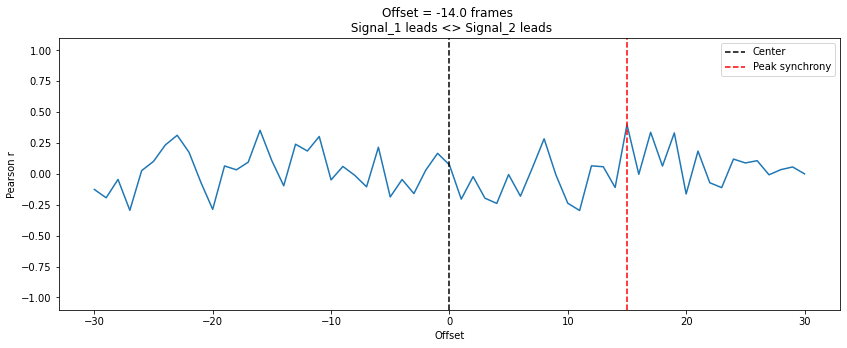

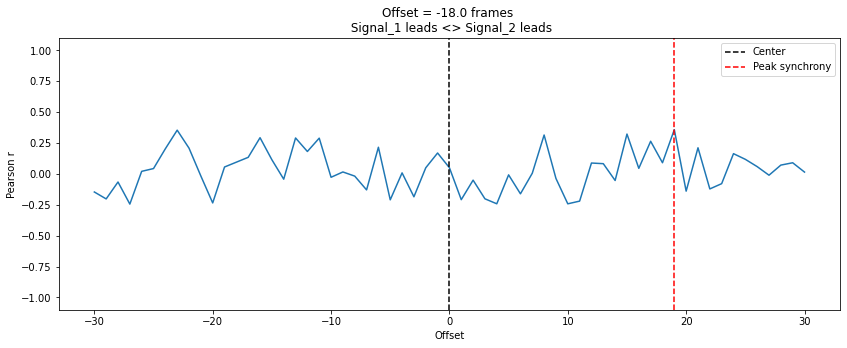

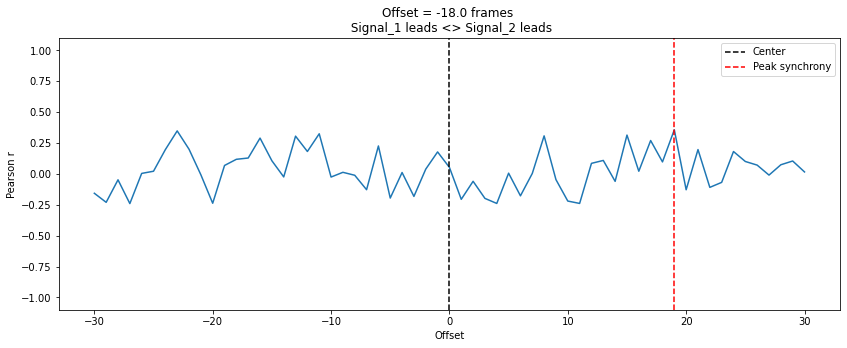

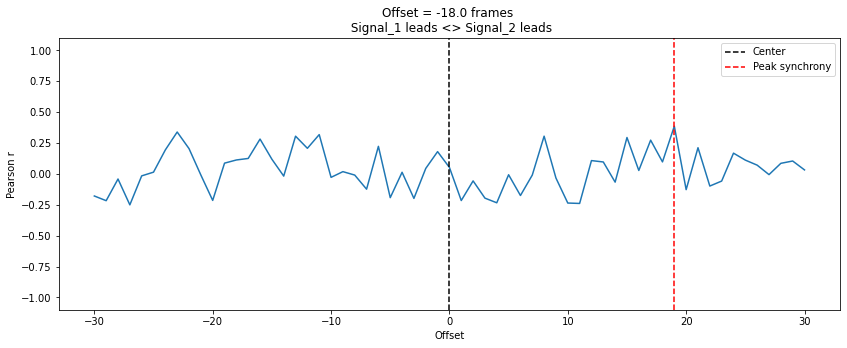

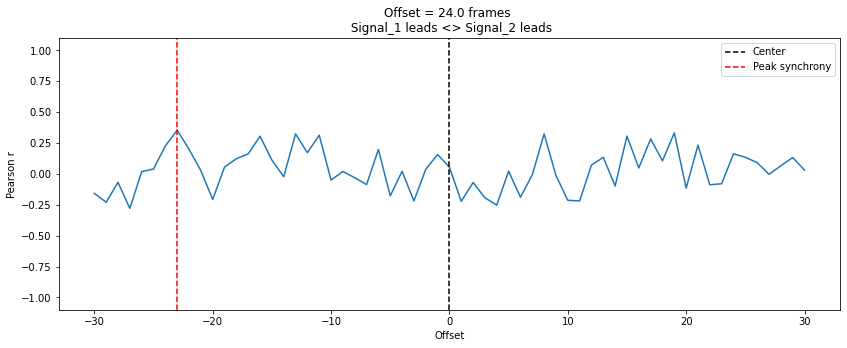

In [33]:
# 绘制前几个事件相关性变化曲线，意义为某设备某时间窗口的流量变化 和 另一设备前后几个时间窗口流量变化的相关性
for i in range(5):
    win = (len(rs[i])-1)//2
    ind = np.array(range(-1*win,win+1))
    offset = np.ceil(len(rs[i])/2)-np.argmax(rs[i]) # np.ceil向上取整    np.argmax最大值的索引

    f,ax=plt.subplots(figsize=(14,5))
    ax.plot(ind,rs[i])
    ax.axvline(ind[(len(rs[i])-1)//2],color='k',linestyle='--',label='Center')
    ax.axvline(ind[np.argmax(rs[i])],color='r',linestyle='--',label='Peak synchrony')
    ax.set(title=f'Offset = {offset} frames \n Signal_1 leads <> Signal_2 leads',
           ylim=[-1.1,1.1],
    #        xlim=[-20,20],
           xlabel='Offset',ylabel='Pearson r'
          )
    # ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
    plt.legend()
    plt.savefig('./output/pearsonTimeWin'+str(i+1)+'.png',dpi=600)
    plt.show()

In [34]:
rs.shape

(910, 61)

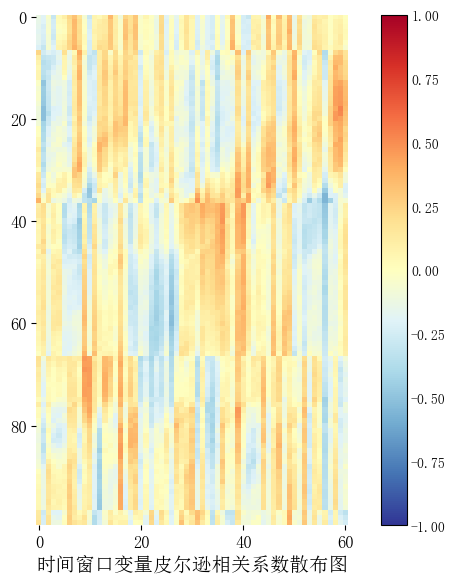

In [35]:
plt.rcdefaults()
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
plt.rcParams.update(config)
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文编码
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

plt.figure(figsize=(7, 6)) # 创建画板,dpi=150
ax = plt.axes()

im = ax.imshow(rs[0:100], cmap="RdYlBu_r", vmin=-1, vmax=1)#


# 横轴相关设置
# ax.tick_params(axis='x', labelsize=10, direction='in', pad=3, length=2.7, width=0)
# ax.set_xticks(np.array(range(0,len(rs))))  # 设置x轴坐标
# ax.set_xticklabels(rs.columns, rotation=0)  # 设置x轴标签旋转角度
ax.set_xlabel("时间窗口变量皮尔逊相关系数散布图", fontsize=14)
# 纵轴相关设置
# ax.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)
# ax.set_yticks(np.array(range(0,len(rs))))  # 设置x轴坐标
# ax.set_yticklabels(rs.index)

# plt.colorbar(im).ax.set_ylabel("", rotation=0)
a = plt.colorbar(im).ax
# a.set_ylabel("", rotation=0)
# a.spines['top'].set_visible(False)
# a.spines['right'].set_visible(False)
# a.spines['bottom'].set_visible(False)
# a.spines['left'].set_visible(False)
a.tick_params(axis='y', labelsize=10, direction='in', pad=3, length=2.7, width=0)

#去掉边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('./output/pearsonTime.png', dpi=600)
plt.show()

In [ ]:
# 加窗的时间滞后互相关
seconds = 5
fps = 30
no_splits = 20
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['S1_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['S2_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Window epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);

# 滑动窗口时间滞后互相关
seconds = 5
fps = 30
window_size = 300 #样本
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['S1_Joy'].iloc[t_start:t_end]
    d2 = df['S2_Joy'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
plt.show()

# 优化调度策略概括总结

关于相关性：

3.1部分产销相关度实际上包含于3.3部分，是时间相关度中的一种特殊情况，即同时刻的相关性。

计算数据间的相关性需要较为丰富的历史数据，所以对于历史数据的相关性分析，可以作为系统实际运行中流量权重分配的先验指导。

主要的量化调度方法还是根据3.2部分思路实现，通过使用量权重制定一般情况下的调度策略。一般情况指煤气产量相对丰富（生成量和煤气柜供应能力的总和）的情况，发生煤气供应量不足的情况，优先保障重点设备的煤气供应，这里从设备连续工作必要性和停产减产经济性角度综合分析，进行保障优先级的排序。



# /////////////////////////////////////////////test//////////////////////////////////////////

## 皮尔逊相关系数

In [13]:
import random
import pandas as pd

n = 10000
X = [random.normalvariate(100, 10) for i in range(n)] # 随机生成服从均值100，标准差10的正态分布序列
Y = [random.normalvariate(100, 10) for i in range(n)] # 随机生成服从均值100，标准差10的正态分布序列
Z = [i*j for i,j in zip(X,Y)]
df = pd.DataFrame({"X":X,"Y":Y,"Z":Z})

In [14]:
df

X           Y             Z
0     100.421549   97.862558   9827.509710
1      99.971354   99.699526   9967.096625
2     101.602533  107.876543  10960.529968
3      99.989794   94.589813   9458.015910
4     110.144701  102.004083  11235.209224
...          ...         ...           ...
9995  103.314956   94.184231   9730.639752
9996  105.513044  103.979030  10971.143960
9997  113.870245   91.996010  10475.608238
9998   90.903916  111.341786  10121.404451
9999   93.631968   98.293588   9203.422062

[10000 rows x 3 columns]

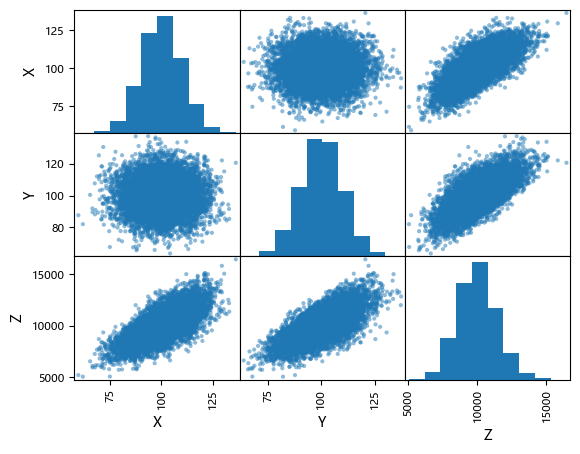

In [15]:
# 绘制散点图矩阵
pd.plotting.scatter_matrix(df)
plt.show()


### 方法一

In [16]:
# pandas.corr 函数（无显著性检验）
df.corr(method="pearson") # 可选值为{‘pearson’:‘皮尔森’, ‘kendall’:‘肯德尔秩相关’, ‘spearman’:‘斯皮尔曼’} min_periods=1 样本最少的数据量


X         Y         Z
X  1.000000 -0.004623  0.702722
Y -0.004623  1.000000  0.704617
Z  0.702722  0.704617  1.000000

### 方法二

In [17]:
from scipy.stats import pearsonr
# scipy.stats.pearsonr 函数 （有显著性检验）
r = pearsonr(df['X'],df['Z'])
print("pearson系数：",r[0])
print("   P-Value：",r[1])


pearson系数： 0.7027219870990848
   P-Value： 0.0


In [18]:
r

(0.7027219870990848, 0.0)

In [19]:
# pandas.corr 加 scipy.stats.pearsonr 获取相关系数检验P值矩阵
def GetPvalue_Pearson(x,y):
    return pearsonr(x,y)[1]

df.corr(method=GetPvalue_Pearson)


X         Y    Z
X  1.000000  0.643917  0.0
Y  0.643917  1.000000  0.0
Z  0.000000  0.000000  1.0

## 边框设置

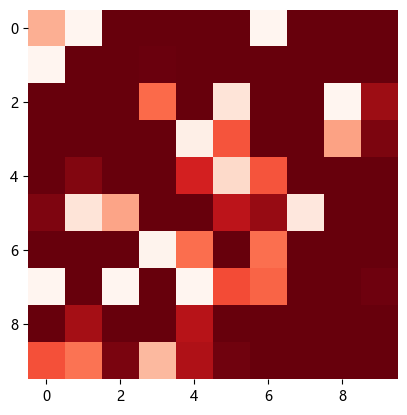

In [20]:
import numpy as np
import matplotlib.pyplot as plt 
# 数据准备
data=np.random.rand(10,10)
fig, ax=plt.subplots()
data[data==-1]=np.nan#去掉缺省值-1
im =ax.imshow(data,interpolation='none',cmap='Reds_r',vmin=0.6,vmax=.9)#不插值
  
#去掉边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


## 求梯度-最小二乘

利用最小二乘法拟合直线，实现了对一系列点拟合出其最接近的直线，并给出公式，包括斜率和截距。

两个函数结果是一样的

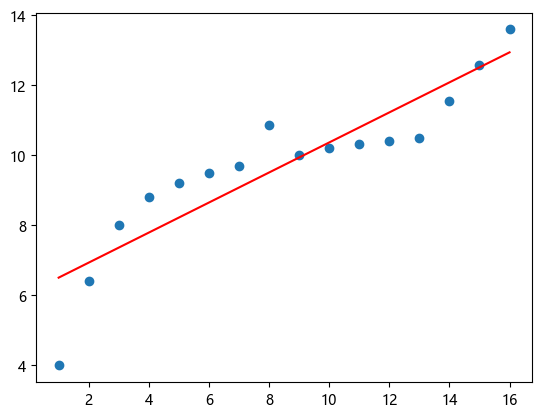

In [24]:
# 核心代码，求斜率w,截距b
def fit(data_x, data_y):
    m = len(data_y)
    x_bar = np.mean(data_x)
    sum_yx = 0
    sum_x2 = 0
    sum_delta = 0
    for i in range(m):
        x = data_x[i]
        y = data_y[i]
        sum_yx += y * (x - x_bar)
        sum_x2 += x ** 2
    # 根据公式计算w
    w = sum_yx / (sum_x2 - m * (x_bar ** 2))

    for i in range(m):
        x = data_x[i]
        y = data_y[i]
        sum_delta += (y - w * x)
    b = sum_delta / m
    return w, b
# 模拟数据
x = np.arange(1, 17, 1)
y = np.array([4.00, 6.40, 8.00, 8.80, 9.22, 9.50, 9.70, 10.86, 10.00, 10.20, 10.32, 10.42, 10.50, 11.55, 12.58, 13.60])
# 计算并绘制
w, b = fit(x, y)
pred_y = w * x + b
plt.scatter(x, y)
plt.plot(x, pred_y, c='r', label='line')
plt.show()


In [25]:
w

0.4291617647058824

In [21]:
def compute_trend(*y):
    """
    计算数据的趋势(线性回归求斜率，最小二乘法)
    """
    x = np.arange(len(y[0])) + 1  # 横轴
    y = np.array(y)  # 纵轴
    xymean = np.mean(np.multiply(x, y), axis=1)  # axis=0是batch
    xmeany = np.mean(x) * np.mean(y, axis=1)
    x2mean = np.square(x).mean()
    xmean2 = x.mean()**2
    trend = (xymean-xmeany)/(x2mean - xmean2)
    return trend


In [26]:
compute_trend(y)

array([0.42916176])

In [22]:
ser.values[0:10,0]

array([25467.338037, 31286.218463, 27052.133988, 26449.380349,
       27623.320584, 27681.23716 , 27956.587722, 28434.027261,
       27274.288198, 28169.987671])

In [23]:
compute_trend(ser.values[0:10,0])

array([46.84448431])

In [29]:
x = np.arange(0, 10, 1)
y = ser.values[0:10,0]
w, b = fit(x, y)
w

46.84448430909084

In [28]:
np.arange(0, 10, 1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## 灰色关联度

### 1

In [14]:
import numpy as np

mom_ = [3439,4002,4519,4995,5566]
son_ = [[341,409,556,719,903],[183,196,564,598,613],[3248,3856,6029,7358,8880]]

mom_ = np.array(mom_)
son_ = np.array(son_)

son_ = son_.T / son_.mean(axis=1)
mom_ = mom_/mom_.mean()

for i in range(son_.shape[1]):
    son_[:,i] = abs(son_[:,i]-mom_.T)

Mmin = son_.min()
Mmax = son_.max()
cors = (Mmin + 0.5*Mmax)/(son_+0.5*Mmax)
Mmean = cors.mean(axis = 0)
print(Mmean)


[0.65032645 0.46734775 0.64955454]


### 2

In [15]:
# 无量纲化
def dimensionlessProcessing(df):
    newDataFrame = pd.DataFrame(index=df.index)
    columns = df.columns.tolist()
    for c in columns:
        d = df[c]
        MAX = d.max()
        MIN = d.min()
        MEAN = d.mean()
        newDataFrame[c] = ((d - MEAN) / (MAX - MIN)).tolist()
    return newDataFrame

def GRA_ONE(gray, m=0):
    # 读取为df格式
    gray = dimensionlessProcessing(gray)
    # 标准化
    std = gray.iloc[:, m]  # 为标准要素
    gray.drop(str(m),axis=1,inplace=True)
    ce = gray.iloc[:, 0:]  # 为比较要素
    shape_n, shape_m = ce.shape[0], ce.shape[1]  # 计算行列

    # 与标准要素比较，相减
    a = zeros([shape_m, shape_n])
    for i in range(shape_m):
        for j in range(shape_n):
            a[i, j] = abs(ce.iloc[j, i] - std[j])

    # 取出矩阵中最大值与最小值
    c, d = amax(a), amin(a)

    # 计算值
    result = zeros([shape_m, shape_n])
    for i in range(shape_m):
        for j in range(shape_n):
            result[i, j] = (d + 0.5 * c) / (a[i, j] + 0.5 * c)

    # 求均值，得到灰色关联值,并返回
    result_list = [mean(result[i, :]) for i in range(shape_m)]
    result_list.insert(m,1)
    return pd.DataFrame(result_list)


def GRA(DataFrame):
    df = DataFrame.copy()
    list_columns = [
        str(s) for s in range(len(df.columns)) if s not in [None]
    ]
    df_local = pd.DataFrame(columns=list_columns)
    df.columns=list_columns
    for i in range(len(df.columns)):
        df_local.iloc[:, i] = GRA_ONE(df, m=i)[0]
    return df_local


In [17]:
ser

焦化外供         套筒窑1         套筒窑2         套筒窑3          炼钢厂  \
0       25467.338037   541.428861  4106.154383  3689.881443  7776.021483   
1       31286.218463   551.789307  4107.876714  3689.791693  7626.024847   
2       27052.133988   554.211750  4109.599045  3689.701942  7751.425194   
3       26449.380349   557.664914  4111.321376  3689.612192  7759.828599   
4       27623.320584   504.572694  4113.043708  3689.522441  7781.008152   
...              ...          ...          ...          ...          ...   
132475  21368.095128  1355.322969   568.961306     0.000005  5618.701037   
132476  21662.745531  1336.454296   560.241123     0.000005  5463.675277   
132477  24639.599501  1284.591330   649.060286     0.000005  5409.511025   
132478  21754.553512  1311.176787   519.891020     0.000005  5347.181945   
132479  21167.228577  1276.500679   490.625415     0.000005  5437.968611   

                 锅炉         焦化放散  
0       6687.897648  3457.050708  
1       6606.700431  5704.971697  
2       6413.561240  5393.052193  
3       6792.389245  3605.506864  
4       6866.979935  4705.525809  
...             ...          ...  
132475  3708.340618   103.000000  
132476  3703.717722   103.000000  
132477  3700.878349   103.000000  
132478  3706.929803   103.000000  
132479  3706.271309   103.000000  

[132480 rows x 7 columns]

In [16]:
dimensionlessProcessing(ser[0:10])

焦化外供      套筒窑1      套筒窑2      套筒窑3       炼钢厂        锅炉      焦化放散
0 -0.390473  0.317393 -0.500000  0.312701 -0.022341 -0.028531 -0.634939
1  0.609527  0.418633 -0.388889  0.122649 -0.528622 -0.207609  0.365061
2 -0.118119  0.442305 -0.277778 -0.067406 -0.105360 -0.633571  0.226302
3 -0.221704  0.476049 -0.166667 -0.257459 -0.076997  0.201921 -0.568898
4 -0.019958 -0.042761 -0.055556 -0.447514 -0.005510  0.366429 -0.079548
5 -0.010004 -0.312971  0.055556 -0.130000  0.143696  0.127828  0.087903
6  0.037316 -0.247122  0.166667  0.552486  0.254426  0.170831 -0.079597
7  0.119366 -0.523951  0.277778 -0.378667  0.471378  0.335395  0.166363
8 -0.079940 -0.260130  0.388889 -0.089522  0.207024  0.144240  0.218082
9  0.073989 -0.267445  0.500000  0.382734 -0.337695 -0.476932  0.299272

In [22]:
GRA(ser[0:10])

NameError: name 'amax' is not defined

## 图片汉字宋体

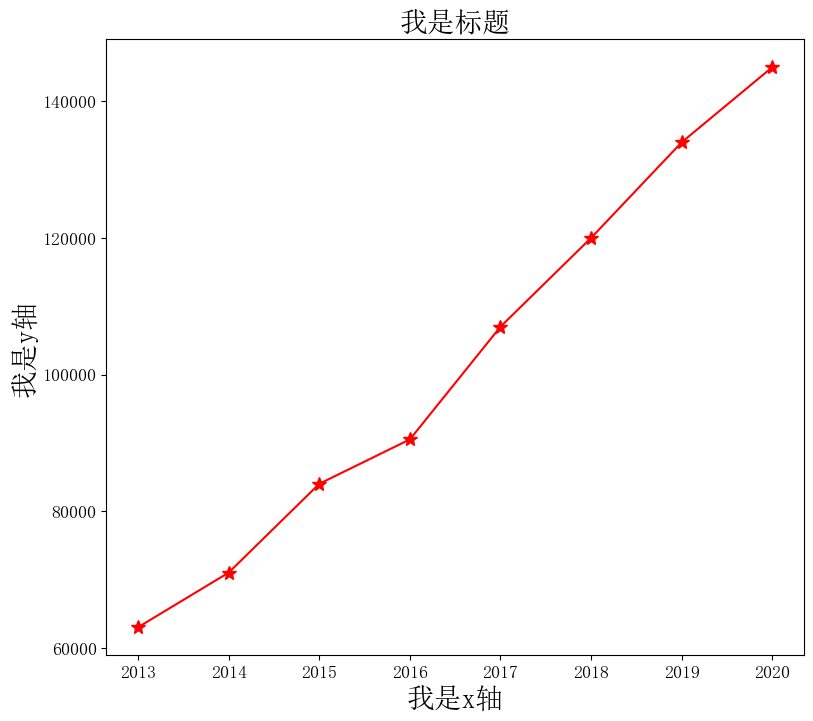

In [98]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 15,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

x_data = ['2013','2014','2015','2016','2017','2018','2019','2020']  
y_data = [63000,71000,84000,90500,107000,120000,134000,145000] 
plt.figure(figsize=(9,8))
plt.plot(x_data, y_data, "r", marker='*', ms=10, label="a")
plt.xlabel("我是x轴", fontsize = 20)
plt.ylabel("我是y轴", fontsize = 20)
plt.title('我是标题', fontsize = 20)
plt.tick_params(labelsize=13)
plt.savefig("折线图.png")
plt.show()


## 聚类

聚类是在特征空间输入数据中发现自然组的无监督问题。

### test

In [156]:
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot

# 定义数据集
X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 为每个类的样本创建散点图

In [157]:
X

array([[-0.42201837,  1.13872531, -0.84967447, -0.23030529],
       [ 0.52142875,  1.17910351,  0.33230182,  2.01337401],
       [-1.6081427 , -1.21381115, -0.56853882,  0.89282739],
       ...,
       [-0.37690853,  1.3240422 , -0.53768278, -0.61181932],
       [ 0.77704981,  1.85925054, -0.6352965 , -1.0205054 ],
       [-1.21998413, -1.37352957, -1.21610236,  1.23021638]])

In [182]:
X.shape

(1000, 4)

In [158]:
y

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,

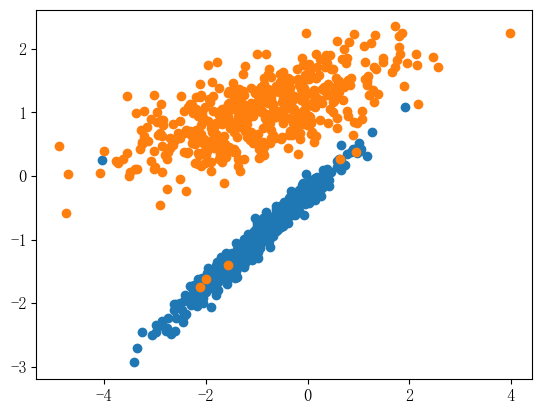

In [159]:
# 为每个类的样本创建散点图
for class_value in range(2):
# 获取此类的示例的行索引
    row_ix = where(y == class_value)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### 创建数据集

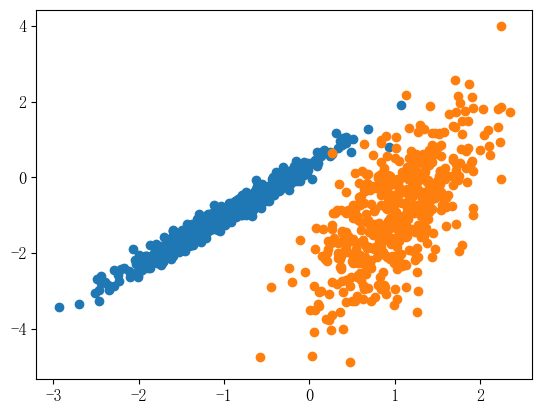

In [144]:
# 综合分类数据集
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot
# 定义数据集
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 为每个类的样本创建散点图
for class_value in range(2):
# 获取此类的示例的行索引
    row_ix = where(y == class_value)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### 亲和力传播

要调整的主要配置是将“ 阻尼 ”设置为0.5到1

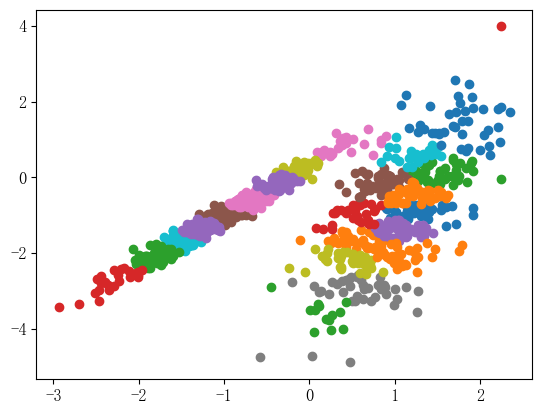

In [143]:
# 亲和力传播聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = AffinityPropagation(damping=0.9)
# 匹配模型
model.fit(X)
# 为每个示例分配一个集群
yhat = model.predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
# 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### 聚合聚类

聚合聚类涉及合并示例，直到达到所需的群集数量为止。它是层次聚类方法的更广泛类的一部分，通过 AgglomerationClustering 类实现的，主要配置是“ n _ clusters ”集，这是对数据中的群集数量的估计，例如2。

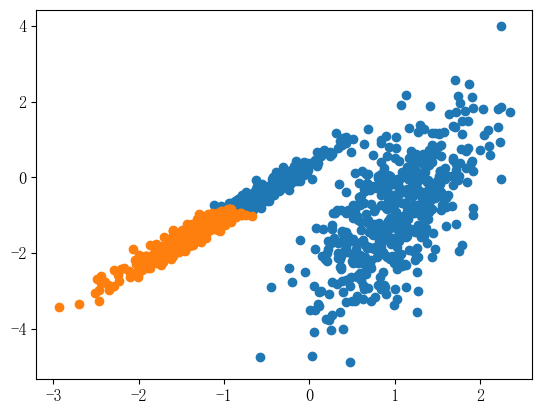

In [142]:
# 聚合聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = AgglomerativeClustering(n_clusters=2)
# 模型拟合与聚类预测
yhat = model.fit_predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
# 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### BIRCH

BIRCH 聚类（ BIRCH 是平衡迭代减少的缩写，聚类使用层次结构)包括构造一个树状结构，从中提取聚类质心。BIRCH 递增地和动态地群集传入的多维度量数据点，以尝试利用可用资源（即可用内存和时间约束）产生最佳质量的聚类。

它是通过 Birch 类实现的，主要配置是“ threshold ”和“ n _ clusters ”超参数，后者提供了群集数量的估计。

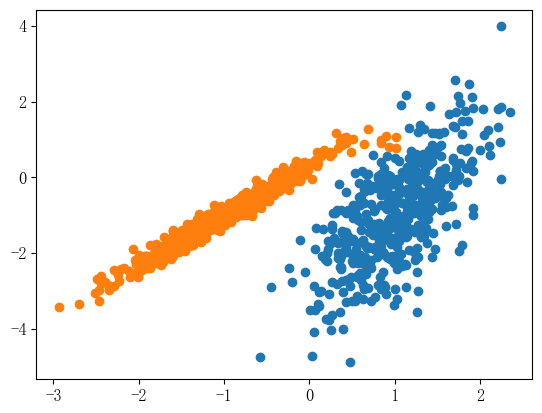

In [145]:
# birch聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = Birch(threshold=0.01, n_clusters=2)
# 适配模型
model.fit(X)
# 为每个示例分配一个集群
yhat = model.predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### DBSCAN

DBSCAN 聚类（其中 DBSCAN 是基于密度的空间聚类的噪声应用程序）涉及在域中寻找高密度区域，并将其周围的特征空间区域扩展为群集。

它是通过 DBSCAN 类实现的，主要配置是“ eps ”和“ min _ samples ”超参数。

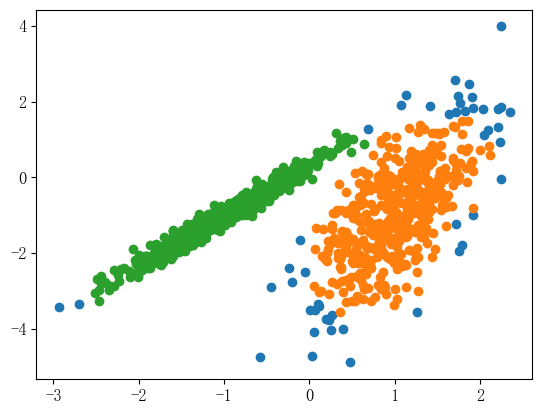

In [146]:
# dbscan 聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = DBSCAN(eps=0.30, min_samples=9)
# 模型拟合与聚类预测
yhat = model.fit_predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### K均值

K-均值聚类可以是最常见的聚类算法，并涉及向群集分配示例，以尽量减少每个群集内的方差。

它是通过 K-均值类实现的，要优化的主要配置是“ n _ clusters ”超参数设置为数据中估计的群集数量。

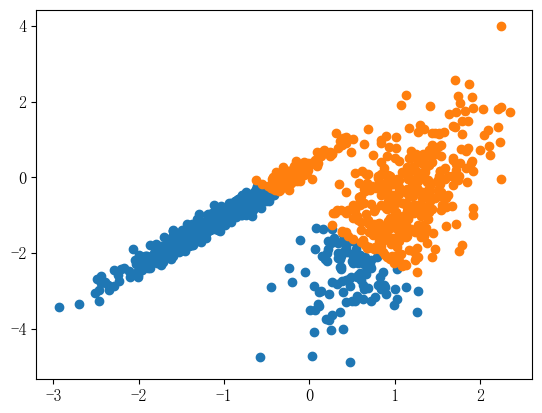

In [147]:
# k-means 聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = KMeans(n_clusters=2)
# 模型拟合
model.fit(X)
# 为每个示例分配一个集群
yhat = model.predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### Mini-Batch K-均值

Mini-Batch K-均值是 K-均值的修改版本，它使用小批量的样本而不是整个数据集对群集质心进行更新，这可以使大数据集的更新速度更快，并且可能对统计噪声更健壮。

它是通过 MiniBatchKMeans 类实现的，要优化的主配置是“ n _ clusters ”超参数，设置为数据中估计的群集数量。

C:\Users\Administrator\Desktop\env37_1\lib\site-packages\sklearn\cluster\_kmeans.py:1047: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


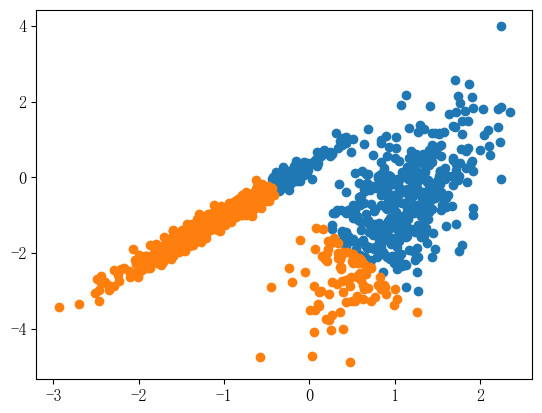

In [148]:
# mini-batch k均值聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = MiniBatchKMeans(n_clusters=2)
# 模型拟合
model.fit(X)
# 为每个示例分配一个集群
yhat = model.predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### 均值漂移聚类

均值漂移聚类涉及到根据特征空间中的实例密度来寻找和调整质心。

它是通过 MeanShift 类实现的，主要配置是“带宽”超参数。

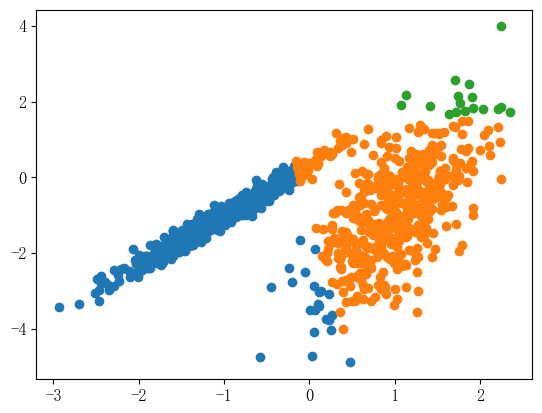

In [149]:
# 均值漂移聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = MeanShift()
# 模型拟合与聚类预测
yhat = model.fit_predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### OPTICS 聚类

OPTICS 聚类（ OPTICS 短于订购点数以标识聚类结构）是上述 DBSCAN 的修改版本。

它是通过 OPTICS 类实现的，主要配置是“ eps ”和“ min _ samples ”超参数。

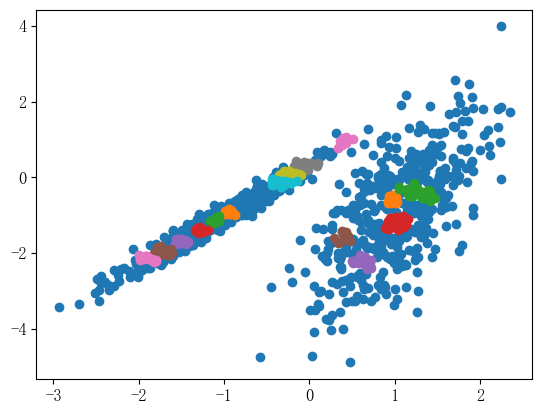

In [150]:
# optics聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import OPTICS
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = OPTICS(eps=0.8, min_samples=10)
# 模型拟合与聚类预测
yhat = model.fit_predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### 光谱聚类

光谱聚类是一类通用的聚类方法，取自线性线性代数。

它是通过 Spectral 聚类类实现的，而主要的 Spectral 聚类是一个由聚类方法组成的通用类，取自线性线性代数。要优化的是“ n _ clusters ”超参数，用于指定数据中的估计群集数量。

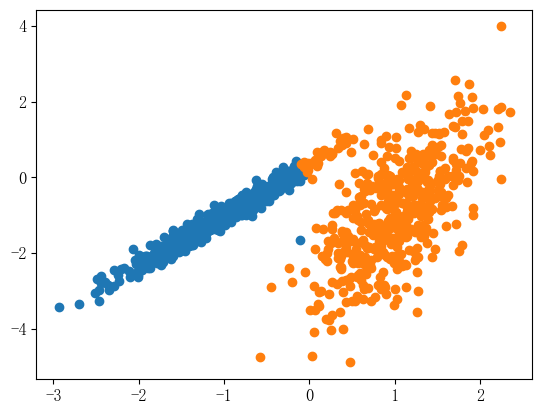

In [151]:
# spectral clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = SpectralClustering(n_clusters=2)
# 模型拟合与聚类预测
yhat = model.fit_predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

### 高斯混合模型

高斯混合模型总结了一个多变量概率密度函数，顾名思义就是混合了高斯概率分布。它是通过 Gaussian Mixture 类实现的，要优化的主要配置是“ n _ clusters ”超参数，用于指定数据中估计的群集数量。

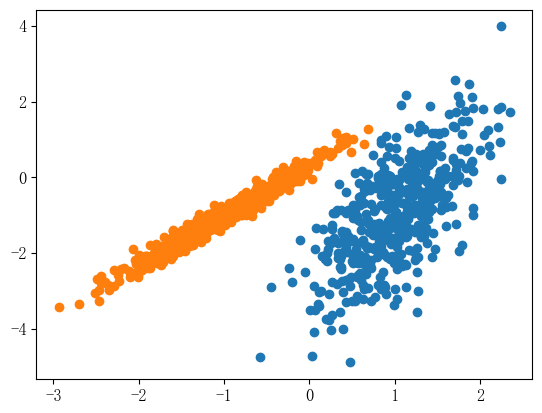

In [152]:
# 高斯混合模型
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# 定义数据集
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# 定义模型
model = GaussianMixture(n_components=2)
# 模型拟合
model.fit(X)
# 为每个示例分配一个集群
yhat = model.predict(X)
# 检索唯一群集
clusters = unique(yhat)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = where(yhat == cluster)
    # 创建这些样本的散布
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
pyplot.show()

## 数组

In [32]:
cal1 = np.zeros((3,4))
cal2 = np.zeros((3,4))
cal3 = np.zeros((3,4))
cal4 = np.zeros((3,4))
cal5 = np.zeros((3,4))
cal6 = np.zeros((3,4))
cal7 = np.zeros((3,4))
cal =[cal1,cal2,cal3,cal4,cal5,cal6,cal7]
cal

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

In [38]:
cal[0][2,3]=9
cal

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 9.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

In [42]:
cal[0][2]

array([0., 0., 0., 9.])

## pandas输出表格

<AxesSubplot:>

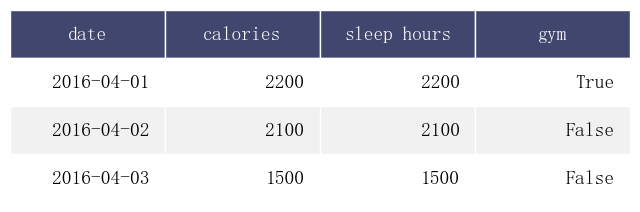

In [77]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import six

df = pd.DataFrame()

df['date'] = ['2016-04-01', '2016-04-02', '2016-04-03']

df['calories'] = [2200, 2100, 1500]

df['sleep hours'] = [2200, 2100, 1500]

df['gym'] = [True, False, False]

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,

    header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',

    bbox=[0, 0, 1, 1], header_columns=0,

    ax=None, **kwargs):

    if ax is None:

        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])

        fig, ax = plt.subplots(figsize=size)

        ax.axis('off')

        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

        mpl_table.auto_set_font_size(False)

        mpl_table.set_fontsize(font_size)

        for k, cell in six.iteritems(mpl_table._cells):

            cell.set_edgecolor(edge_color)

            if k[0] == 0 or k[1] < header_columns:

                cell.set_text_props(weight='bold', color='w')

                cell.set_facecolor(header_color)
    
            else:

                cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

    return ax

render_mpl_table(df, header_columns=0, col_width=2.0)